## EE 782: Advanced Topics in Machine Learning
### **Assignment 1:** LSTM-based Stock Trading System
> **NAME:** Munish Monga

> **ROLL NO:** 22M2153

> [Github Repo Link](https://github.com/munish30monga/lstm_based_stock_trading_system)

### Table of Contents:
1. [Introduction](#introduction)
2. [Importing Libraries](#importing-libraries)

### Introduction <a id="introduction"></a>

### Importing Libraries <a id="importing-libraries"></a>

In [1]:
import pandas as pd                                             # for data handling  
import numpy as np                                              # for numerical computations               
import pathlib as pl                                            # for path handling
import matplotlib.pyplot as plt                                 # for plotting
import random                                                   # for random number generation
import mplfinance as mpl                                        # for candlestick plotting
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # for normalization
import seaborn as sns                                           # for plotting histograms
import torch                                                    # for deep learning functionality
import torch.nn as nn                                           # for LSTM model
from torch.utils.data import Dataset, DataLoader                # for data loading
from tqdm import tqdm                                           # for progress bar
from pandas.tseries.holiday import USFederalHolidayCalendar     # for US holidays
from pandas.tseries.offsets import CustomBusinessDay            # for US business days

### Hyperparameters <a id="hyperparameters"></a>

In [2]:
batch_size = 128                                                     # batch size for training
random_seed = 42                                                    # for reproducibility
random.seed(random_seed)                                            # set random seed
few_stocks = 4                                                      # used in Q1 to plot few stocks
start_date, end_date = '2020-01-01','2020-02-01'                    # used in Q1c to plot candlesticks chart
device = 'cuda' if torch.cuda.is_available() else 'cpu'             # set device to cuda if available
hidden_dim, num_layers = 32, 1                                      # LSTM model parameters
seq_length = 10                                                     # sequence length for LSTM model  
pred_horizon = 1                                                    # prediction horizon  
predict = 'Close'                                                   # Predict the closing or opening price
epochs = 10                                                         # number of epochs for training
learning_rate = 0.01                                                # learning rate for training
weight_decay = 0.03                                                 # weight decay for regularization
regularize = False                                                  # to regularize the model or not
years_to_keep = 10                                                  # number of years to keep for training
patience = 4                                                        # patience for early stopping
save_best = True                                                    # save the best model or not

### Q1. Exploring Dataset <a id="exploring-dataset"></a>
> Familiarize yourself with the input data `sp500_tickers_A-D_1min_1pppix.zip`

In [3]:
data_dir = pl.Path('./dataset/sp500_tickers_A-D_1min_1pppix/')             # Setting path to the data directory
companies_list = data_dir.glob('*.txt')                            # Getting the list of all the files in data dir
stocks = [stock.stem.split('_')[0] for stock in companies_list]    # Getting the list of all the companies
print(stocks)                                                      # Printing the name of stocks
print("Total number of stocks:",len(stocks))                       # Printing the total number of stocks

['C', 'AME', 'AZO', 'DNB', 'ADBE', 'ADSK', 'DLTR', 'AVGO', 'DFS', 'CI', 'ANTM', 'ADT', 'ARNC', 'CZR', 'CRM', 'CARR', 'CPB', 'AMBC', 'AN', 'BBY', 'BWA', 'ATVI', 'AMAT', 'ADM', 'D', 'DUK', 'BLK', 'CINF', 'COP', 'CMCSA', 'DISCK', 'CHKP', 'ALK', 'CE', 'CMS', 'ALTR', 'BMRN', 'CAH', 'COF', 'DPZ', 'DLX', 'CNP', 'CAR', 'CBRE', 'ACN', 'CCU', 'CNC', 'ATO', 'CSX', 'BIIB', 'COOP', 'ANET', 'ARE', 'ADI', 'CAG', 'AMP', 'COTY', 'CSCO', 'CTVA', 'BIDU', 'DXC', 'APTV', 'CDW', 'AON', 'CTLT', 'APD', 'CC', 'DDS', 'BF.B', 'DIS', 'CVS', 'CNX', 'AINV', 'ABT', 'AMG', 'ANF', 'BXP', 'DTE', 'BAX', 'CTXS', 'DVN', 'CERN', 'AIV', 'DE', 'CBH', 'CL', 'BIG', 'BTU', 'CHTR', 'DISCA', 'AEE', 'CCL', 'CAT', 'CFG', 'BA', 'AMGN', 'CDNS', 'CTSH', 'CLX', 'BEN', 'BKNG', 'ASH', 'CMA', 'BR', 'DXCM', 'BDX', 'AMZN', 'ABC', 'DVA', 'DOW', 'CHD', 'ASO', 'ADS', 'BSX', 'CF', 'ATGE', 'BUD', 'CHRW', 'DOV', 'BRK.B', 'BK', 'AEP', 'ALL', 'AAPL', 'AIG', 'ATI', 'AXP', 'CVX', 'CBOE', 'ACV', 'DAN', 'DLR', 'DD', 'AIZ', 'ANSS', 'BBBY', 'CDAY', 'AMD'

Let us randomly select few stocks for Q1, seed is kept as 42 for reproducibility.

In [4]:
random_stocks = random.sample(stocks, few_stocks)                 # Selecting few random stocks
print("Randomly Selected Stocks:",random_stocks)                  # Printing the selected stocks

Randomly Selected Stocks: ['ABBV', 'COP', 'DLTR', 'CCI']


Columns names in the following cell are referred from [[1]](#references)

In [3]:
def create_df_dict(stocks):
    """
    Creates a dictionary of dataframes for each stock.
    
    Parameters:
    - stocks (list): A list of stock names.
    
    Returns:
    - df_dict (dict): A dictionary with stock names as keys and their corresponding dataframes as values.
    """
    data_dir = pl.Path('./dataset/sp500_tickers_A-D_1min_1pppix/') 
    df_dict = {}
    for stock in stocks:
        df = pd.read_csv(data_dir / f'{stock}_1min.txt', sep=',', header=None) # Reading the data
        df.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']    # Naming the columns (see reference [1])
        df_dict[stock] = df
    return df_dict

In [24]:
random_stock_dfs_dict = create_df_dict(random_stocks)       # Creating the dataframes dictionary for these random stocks
for stock, df in random_stock_dfs_dict.items():
    print(f"Stock: {stock}, Shape: {df.shape}")            # Printing the shape of each dataframe

Stock: ABBV, Shape: (944746, 6)
Stock: COP, Shape: (1879504, 6)
Stock: DLTR, Shape: (1469385, 6)
Stock: CCI, Shape: (1649392, 6)


In [25]:
print("Stock:",random_stocks[0])                          # Printing the name of first random stock
random_stock_dfs_dict[random_stocks[0]]                   # Printing the dataframe of first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume
0,2013-01-02 08:57:00,24.2381,24.2381,24.2381,24.2381,217
1,2013-01-02 09:07:00,23.6098,23.6098,23.6098,23.6098,200
2,2013-01-02 09:08:00,23.6303,23.6303,23.6303,23.6303,100
3,2013-01-02 09:19:00,23.6986,23.6986,23.6986,23.6986,100
4,2013-01-02 09:29:00,23.6713,23.7054,23.6440,23.6440,1800
...,...,...,...,...,...,...
944741,2022-02-25 18:28:00,149.6000,149.6000,149.6000,149.6000,988
944742,2022-02-25 18:30:00,149.5400,149.5400,149.5400,149.5400,0
944743,2022-02-25 18:46:00,149.5400,149.5400,149.5400,149.5400,200
944744,2022-02-25 19:00:00,149.5400,149.5400,149.5400,149.5400,0


In [26]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]].info()                 # Printing the info of the first random stock                                             

Stock: ABBV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944746 entries, 0 to 944745
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DateTime  944746 non-null  object 
 1   Open      944746 non-null  float64
 2   High      944746 non-null  float64
 3   Low       944746 non-null  float64
 4   Close     944746 non-null  float64
 5   Volume    944746 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 43.2+ MB


In [27]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]].describe()             # Printing the description of the first random stock

Stock: ABBV


,Open,High,Low,Close,Volume
count,944746.000000,944746.000000,944746.000000,944746.000000,9.447460e+05
mean,64.910379,64.936936,64.883632,64.910277,1.680320e+04
std,26.433196,26.442576,26.423622,26.433252,6.605120e+04
min,22.776600,22.824400,22.762900,22.769800,0.000000e+00
25%,43.964825,43.984400,43.945200,43.962600,4.668000e+03
50%,58.418950,58.436750,58.399100,58.419600,8.610000e+03
75%,81.054225,81.089500,81.015100,81.053775,1.600000e+04
max,150.350000,150.360000,150.290000,150.350000,1.305539e+07


#### Data Preprocessing <a id="data-preprocessing"></a>

In [4]:
def get_latest_df_dict(df_dict, years_to_keep):
    """
    Filters each dataframe to keep only the latest data based on a given number of years.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    - years_to_keep (int, optional): Number of years of data to retain. Defaults to 10.
    
    Returns:
    - latest_df_dict (dict): Dictionary containing the latest data for each stock.
    """
    latest_df_dict = {}
    # df_dict_temp = separate_datetime_dfs_dict(df_dict)        # Ensure that the DateTime column is converted to Date and Time columns
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])       # Convert to datetime type
        latest_df = df[df['DateTime'] >= df['DateTime'].max() - pd.DateOffset(years=years_to_keep)]
        latest_df_dict[stock] = latest_df
    
    return latest_df_dict

In [29]:
latest_random_stock_dfs_dict = get_latest_df_dict(random_stock_dfs_dict, years_to_keep) # Getting the latest data for each stock
print(f"Stock: {random_stocks[0]}")
latest_random_stock_dfs_dict[random_stocks[0]]                                           # Printing the latest data for the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume
0,2013-01-02 08:57:00,24.2381,24.2381,24.2381,24.2381,217
1,2013-01-02 09:07:00,23.6098,23.6098,23.6098,23.6098,200
2,2013-01-02 09:08:00,23.6303,23.6303,23.6303,23.6303,100
3,2013-01-02 09:19:00,23.6986,23.6986,23.6986,23.6986,100
4,2013-01-02 09:29:00,23.6713,23.7054,23.6440,23.6440,1800
...,...,...,...,...,...,...
944741,2022-02-25 18:28:00,149.6000,149.6000,149.6000,149.6000,988
944742,2022-02-25 18:30:00,149.5400,149.5400,149.5400,149.5400,0
944743,2022-02-25 18:46:00,149.5400,149.5400,149.5400,149.5400,200
944744,2022-02-25 19:00:00,149.5400,149.5400,149.5400,149.5400,0


Since this stock as only 9 years of data, we keep the entire dataframe as it is. Let us check `latest_df_dict` for some other stock also.

In [30]:
print(f"Stock: {random_stocks[1]}")
random_stock_dfs_dict[random_stocks[1]]

Stock: COP


,DateTime,Open,High,Low,Close,Volume
0,2004-01-02 09:30:00,14.0884,14.0884,14.0884,14.0884,174468
1,2004-01-02 09:31:00,14.0884,14.0906,14.0626,14.0626,12593
2,2004-01-02 09:32:00,14.0691,14.0949,14.0626,14.0928,20726
3,2004-01-02 09:33:00,14.1057,14.1057,14.0949,14.0992,15217
4,2004-01-02 09:34:00,14.0992,14.1014,14.0949,14.0971,3411
...,...,...,...,...,...,...
1879499,2022-02-25 18:59:00,90.9000,90.9000,90.9000,90.9000,100
1879500,2022-02-25 19:00:00,91.2700,91.2700,91.2700,91.2700,0
1879501,2022-02-25 19:10:00,90.9800,90.9800,90.9800,90.9800,500
1879502,2022-02-25 19:51:00,90.9800,90.9800,90.9800,90.9800,100


In [31]:
print(f"Stock: {random_stocks[1]}")
latest_random_stock_dfs_dict[random_stocks[1]]                  

Stock: COP


,DateTime,Open,High,Low,Close,Volume
849347,2012-02-27 07:03:00,41.5472,41.5472,41.5472,41.5472,131
849348,2012-02-27 07:26:00,41.4924,41.4924,41.4924,41.4924,131
849349,2012-02-27 07:42:00,41.5965,41.5965,41.5965,41.5965,131
849350,2012-02-27 08:00:00,41.4924,41.6568,41.4924,41.6568,3014
849351,2012-02-27 08:01:00,41.6294,41.6294,41.6294,41.6294,131
...,...,...,...,...,...,...
1879499,2022-02-25 18:59:00,90.9000,90.9000,90.9000,90.9000,100
1879500,2022-02-25 19:00:00,91.2700,91.2700,91.2700,91.2700,0
1879501,2022-02-25 19:10:00,90.9800,90.9800,90.9800,90.9800,500
1879502,2022-02-25 19:51:00,90.9800,90.9800,90.9800,90.9800,100


In [5]:
def process_df_dict(latest_df_dict):
    """
    Processes the stock market data to exclude data outside trading hours and clean missing minutes or holidays.
    
    Parameters:
    - latest_df_dict (dict): Dictionary containing the latest data for each stock.
    
    Returns:
    - processed_df_dict (dict): Dictionary containing the processed data for each stock.
    """
    processed_df_dict = {}
    
    # Define trading hours
    trading_start = pd.to_datetime("9:30").time()           # 9:30 AM
    trading_end = pd.to_datetime("16:00").time()            # 4:00 PM
    
    for stock, df in latest_df_dict.items():
        
        # Exclude data outside of trading hours
        df = df[df['DateTime'].dt.time.between(trading_start, trading_end)]
        
        # Exclude data with missing minutes or days with holidays (assuming very low volume means holiday)
        volume_threshold = df['Volume'].quantile(0.05)     
        df = df[df['Volume'] > volume_threshold]
        
        processed_df_dict[stock] = df
        
    return processed_df_dict

In [35]:
processed_random_stock_dfs_dict = process_df_dict(latest_random_stock_dfs_dict) # Processing the random stock dataframes

In [36]:
print("Stock:",random_stocks[0])                          # Printing the first random stock
processed_random_stock_dfs_dict[random_stocks[0]]         # Printing the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume
5,2013-01-02 09:30:00,23.8488,23.8488,23.4937,23.7396,120336
6,2013-01-02 09:31:00,23.7396,23.8352,23.6713,23.6713,19199
7,2013-01-02 09:32:00,23.6303,23.6576,23.5962,23.6405,13518
8,2013-01-02 09:33:00,23.6440,23.6508,23.5620,23.6303,6823
9,2013-01-02 09:34:00,23.6371,23.6884,23.6303,23.6440,32448
...,...,...,...,...,...,...
944725,2022-02-25 15:55:00,149.2350,149.3800,149.2200,149.3300,23369
944726,2022-02-25 15:56:00,149.3300,149.3800,149.2500,149.3450,44299
944727,2022-02-25 15:57:00,149.3500,149.4200,149.2900,149.4200,36907
944728,2022-02-25 15:58:00,149.4000,149.4900,149.3800,149.4700,62290


#### Helper Functions <a id="helper-functions"></a>

In [6]:
def separate_datetime_dfs_dict(df_dict):
    """
    Separates the 'DateTime' column of each dataframe into separate 'Date' and 'Time' columns.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - converted_dict (dict): Updated dictionary with separated 'Date' and 'Time' columns.
    """
    converted_dict = {}
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])
        df['Date'] = df['DateTime'].dt.date
        df['Time'] = df['DateTime'].dt.time
        converted_dict[stock] = df
    return converted_dict

In [39]:
random_stock_dfs_dict = separate_datetime_dfs_dict(processed_random_stock_dfs_dict) # Converting the DateTime column to Date and Time columns
print("Stock:",random_stocks[0])                                                    # Printing the first random stock
random_stock_dfs_dict[random_stocks[0]]                                             # Printing the first random stock DataFrame

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume,Date,Time
5,2013-01-02 09:30:00,23.8488,23.8488,23.4937,23.7396,120336,2013-01-02,09:30:00
6,2013-01-02 09:31:00,23.7396,23.8352,23.6713,23.6713,19199,2013-01-02,09:31:00
7,2013-01-02 09:32:00,23.6303,23.6576,23.5962,23.6405,13518,2013-01-02,09:32:00
8,2013-01-02 09:33:00,23.6440,23.6508,23.5620,23.6303,6823,2013-01-02,09:33:00
9,2013-01-02 09:34:00,23.6371,23.6884,23.6303,23.6440,32448,2013-01-02,09:34:00
...,...,...,...,...,...,...,...,...
944725,2022-02-25 15:55:00,149.2350,149.3800,149.2200,149.3300,23369,2022-02-25,15:55:00
944726,2022-02-25 15:56:00,149.3300,149.3800,149.2500,149.3450,44299,2022-02-25,15:56:00
944727,2022-02-25 15:57:00,149.3500,149.4200,149.2900,149.4200,36907,2022-02-25,15:57:00
944728,2022-02-25 15:58:00,149.4000,149.4900,149.3800,149.4700,62290,2022-02-25,15:58:00


In [7]:
def getrandomdate(dfs_dict):
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)           # Ensure that the DateTime column is converted to Date and Time columns
    dates = []
    for stock in dfs_dict:
        dates.append(dfs_dict[stock]['Date'].unique().tolist())
    common_dates = set(dates[0]).intersection(*dates[1:])   # Getting the common dates
    random_date = random.choice(list(common_dates))         # Selecting a random date
    return random_date

In [41]:
random_date = getrandomdate(random_stock_dfs_dict)          # Getting a random date
print("Randomly Selected Date:",random_date)                # Printing the random date

Randomly Selected Date: 2015-01-06


In [8]:
def filter_dfs_by_date(dfs_dict, date):
    date = pd.to_datetime(date).date()
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)        # Ensure that the DateTime column is converted to Date and Time columns
    filtered_dfs_dict = {}
    for stock, df in dfs_dict.items():
        filtered_df = df[df['Date'] == date]
        filtered_dfs_dict[stock] = filtered_df
    return filtered_dfs_dict

In [44]:
filtered_dfs_dict = filter_dfs_by_date(random_stock_dfs_dict, random_date) # Filtering the dfs by the random date
print("Stock:",random_stocks[0])                                           # Printing the first random stock
filtered_dfs_dict[random_stocks[0]]                                        # Printing the first 5 rows of the first random stock

Stock: ABBV


,DateTime,Open,High,Low,Close,Volume,Date,Time
202225,2015-01-06 09:31:00,47.8690,48.0890,47.8690,48.0303,150180,2015-01-06,09:31:00
202226,2015-01-06 09:32:00,48.0281,48.0670,47.9936,48.0574,17743,2015-01-06,09:32:00
202227,2015-01-06 09:33:00,48.0376,48.0523,47.8837,47.9042,18868,2015-01-06,09:33:00
202228,2015-01-06 09:34:00,47.9130,48.0743,47.9130,47.9790,30053,2015-01-06,09:34:00
202229,2015-01-06 09:35:00,47.9790,48.0083,47.9350,47.9863,29876,2015-01-06,09:35:00
...,...,...,...,...,...,...,...,...
202610,2015-01-06 15:56:00,47.2348,47.2605,47.1578,47.1652,33173,2015-01-06,15:56:00
202611,2015-01-06 15:57:00,47.1798,47.2165,47.1432,47.1945,35369,2015-01-06,15:57:00
202612,2015-01-06 15:58:00,47.1872,47.2238,47.1285,47.2165,61010,2015-01-06,15:58:00
202613,2015-01-06 15:59:00,47.2091,47.2165,47.1212,47.1505,65722,2015-01-06,15:59:00


### Q1a. Plotting minute-by-minute closing price series <a id="q1a"></a>
> Plot the minute-by-minute closing price series of few stocks

To illustrate minute-by-minute closing price series better, I have plotted few stocks on a random date that is common to these stocks. Code snippet for the following cell is referred from [[10]](#ref10)

In [7]:
def plot_minute_by_minute(dfs_dict, date):
    filtered_dfs_dict = filter_dfs_by_date(dfs_dict, date) # Filtering the dfs by the date
    stocks = list(filtered_dfs_dict.keys())
    n_stocks = len(stocks)
    nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks

    # Initialize the subplots with 2 columns
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
    
    # Flatten the axes for easy iteration, and then iterate only over the needed number of axes for the given stocks
    axes = axes.ravel()

    # Plot the data for each stock in stocks
    for i, stock in enumerate(stocks):
        ax = axes[i]
        
        # Filter data for the date
        data_for_day = filtered_dfs_dict[stock]
        
        # Plot the data using 'Time' for the x-axis and 'Close' for the y-axis
        ax.plot(data_for_day['Time'].astype(str), data_for_day['Close'], label=f'{stock} Closing Price')
        
        # Set titles and labels
        ax.set_title(f'{stock} Minute-by-Minute Closing Price Series on {date}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        
        # Adjust the x-axis for better readability
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)

    # If the number of stocks is odd, remove the last unused subplot
    if n_stocks % 2 == 1:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

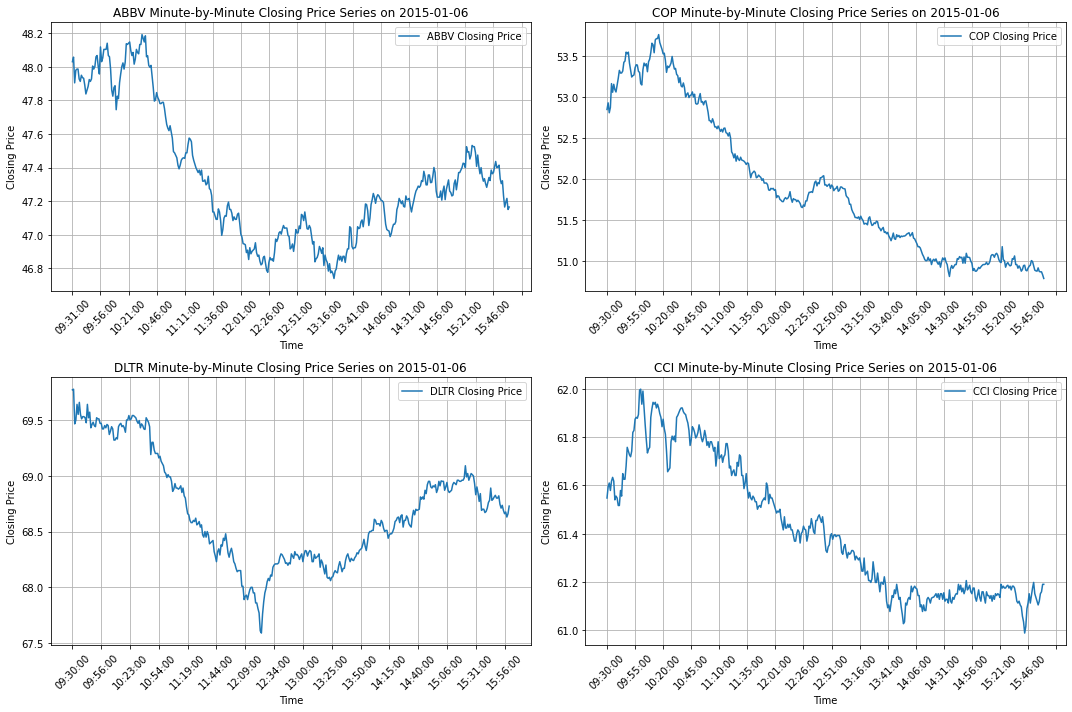

In [46]:
plot_minute_by_minute(random_stock_dfs_dict, random_date)

In [ ]:
plot_minute_by_minute(random_stock_dfs_dict, '2020-05-01')  # this date must be present in all the stocks

### Q1b. Plotting day-by-day closing price series <a id="q1b"></a>
> Plot the day-by-day closing price series of a few stocks

Code snippet for the following cell is referred from [[10]](#references)

In [8]:
def plot_day_by_day_CP(dfs_dict, combine_plots):
    dfs_dict = separate_datetime_dfs_dict(dfs_dict)     # Ensure that the DateTime column is converted to Date and Time columns
    stocks = list(dfs_dict.keys())
    n_stocks = len(stocks)
    
    if combine_plots:                           # If combine_plots is True, plot all the stocks in a single plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for stock in stocks:
            ax.plot(dfs_dict[stock]['Date'], dfs_dict[stock]['Close'], label=f'{stock} Closing Price')
        
        ax.set_title('Day-by-Day Closing Price Series')
        ax.set_xlabel('Date')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks

        # Initialize the subplots with 2 columns
        fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
        
        # Flatten the axes for easy iteration, and then iterate only over the needed number of axes for the given stocks
        axes = axes.ravel()

        # Plot the data for each stock in stocks
        for i, stock in enumerate(stocks):
            ax = axes[i]
            
            # Plot the data using 'Date' for the x-axis and 'Close' for the y-axis
            ax.plot(dfs_dict[stock]['Date'], dfs_dict[stock]['Close'], label=f'{stock} Closing Price')
            
            # Set titles and labels
            ax.set_title(f'{stock} Day-by-Day Closing Price Series')
            ax.set_xlabel('Date')
            ax.set_ylabel('Closing Price')
            ax.legend()
            ax.grid(True)
            
            # Adjust the x-axis for better readability
            ax.xaxis.set_major_locator(plt.MaxNLocator(20))
            ax.xaxis.set_tick_params(rotation=45)

        # If the number of stocks is odd, remove the last unused subplot
        if n_stocks % 2 == 1:
            fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()

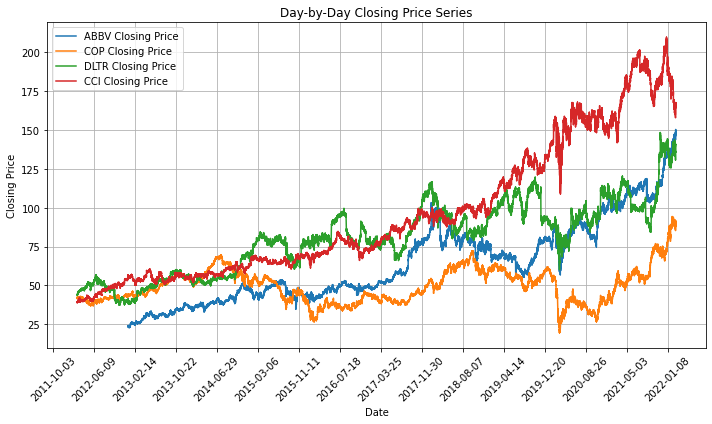

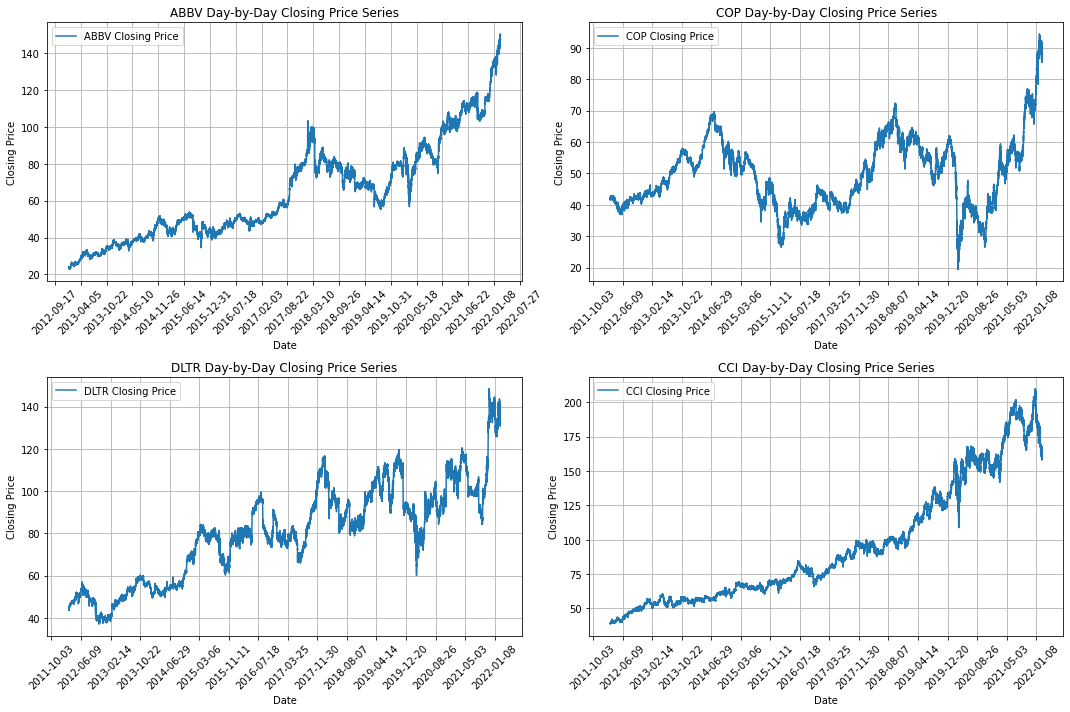

In [50]:
plot_day_by_day_CP(random_stock_dfs_dict, combine_plots=True)  # Plotting all the stocks in a single plot
plot_day_by_day_CP(random_stock_dfs_dict, combine_plots=False) # Plotting each stock in a separate plot

### Q1c. Plotting candlestick chart <a id="q1c"></a>
> Plot a complete candlestick chart with volume on secondary y-axis for a few stocks with a
time period of your choice

Resampling stock data to daily frequency to plot for better visualization of candlestick chart. `Start_Date` and `End_Date` for the time period are specified in the [hyperparameters](#hyperparameters) section. Note that increasing the time period will lead to more data points and a more cluttered candlestick chart. Hence, the time period is kept to one month.

In [9]:
def resample_dfs(dfs_dict, start_date, end_date, freq):
    resampled_dfs_dict = {}
    
    for stock, data in dfs_dict.items():
        data['DateTime'] = pd.to_datetime(data['DateTime'])  # Convert to datetime type
        
        resampled_data = data.resample(freq, on='DateTime').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        })
        
        # Drop any rows with NaN values (this can happen if there's no data for a particular day)
        resampled_data = resampled_data.dropna()
        resampled_dfs_dict[stock] = resampled_data

    # Convert start_date and end_date to datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter the resampled data based on the start and end date
    for stock, data in resampled_dfs_dict.items():
        mask = (data.index >= start_date) & (data.index <= end_date)
        resampled_dfs_dict[stock] = data[mask]

    return resampled_dfs_dict

In [53]:
resampled_dfs_dict = resample_dfs(random_stock_dfs_dict, start_date, end_date, freq='D')
print(f"Resampled data for {random_stocks[0]} from {start_date} to {end_date}:")
resampled_dfs_dict[random_stocks[0]] # Printing the resampled data for the first random stock

Resampled data for ABBV from 2020-01-01 to 2020-02-01:


,Open,High,Low,Close,Volume
DateTime,,,,,
2020-01-02,79.6362,80.1552,79.2067,80.1552,3461035
2020-01-03,78.9024,79.9942,78.6608,79.3498,3810736
2020-01-06,78.9471,80.2000,78.7324,80.0031,4483722
2020-01-07,79.5825,80.1284,78.9829,79.5199,5381643
2020-01-08,79.8062,80.5937,79.5288,80.1105,5616510
2020-01-09,80.5132,80.7459,79.6899,80.7280,5299918
2020-01-10,80.7638,80.7996,79.4930,79.6899,5828162
2020-01-13,80.1463,80.1463,78.6742,79.1977,6619104
2020-01-14,78.9979,80.2087,78.6986,79.9865,5538500


In [10]:
def plot_candlesticks(dfs_dict, start_date, end_date, freq):
    resampled_dfs_dict = resample_dfs(dfs_dict, start_date, end_date, freq=freq)
    for stock, df in resampled_dfs_dict.items():
        # Create a custom plot configuration for the volume (to be shown on a secondary y-axis)
        volume_plt = [mpl.make_addplot(df['Volume'], panel=1, secondary_y='auto', color='g')]

        # Plot the candlestick chart
        mpl.plot(df, 
                 type='candle',
                 style='charles',
                 title=f'{stock} Candlestick Chart ({start_date} to {end_date})',
                 ylabel='Price',
                 addplot=volume_plt,
                 volume=True,
                 show_nontrading=True,      # to show gap for non trading days
                 figsize=(10, 5))

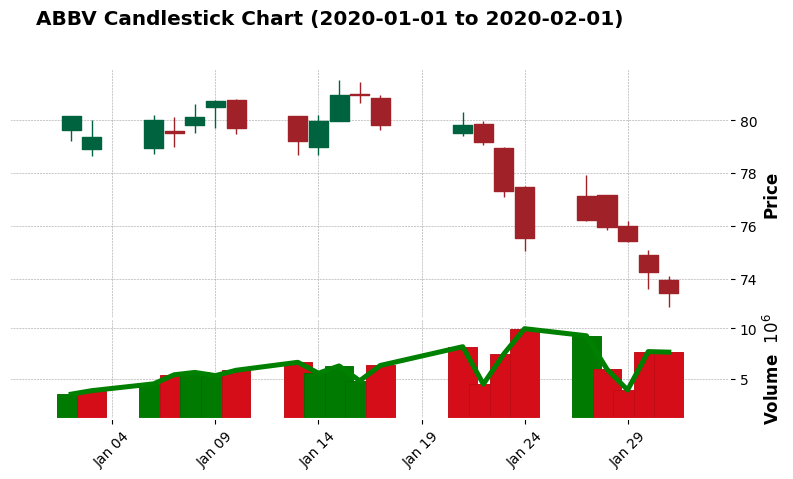

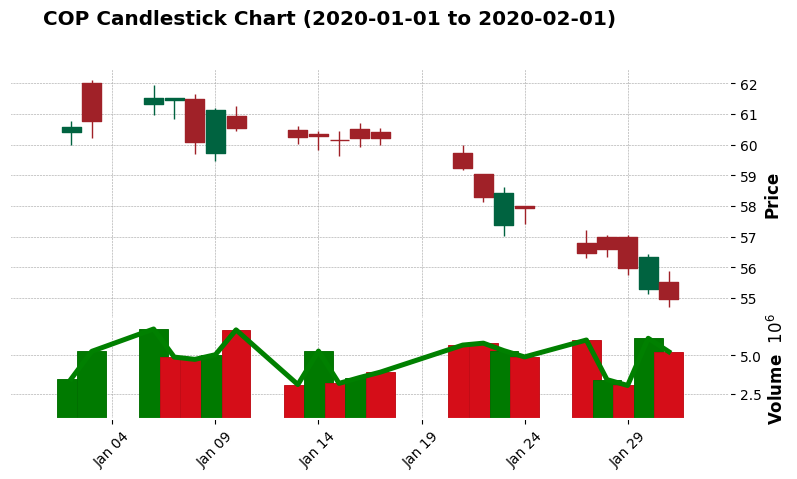

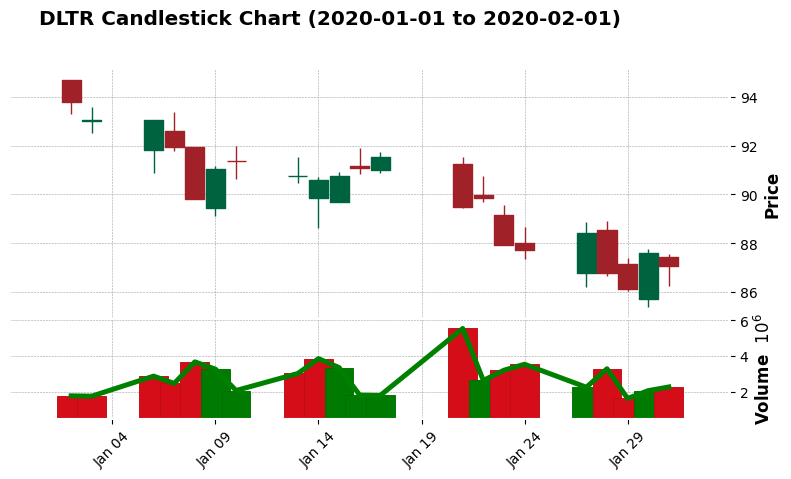

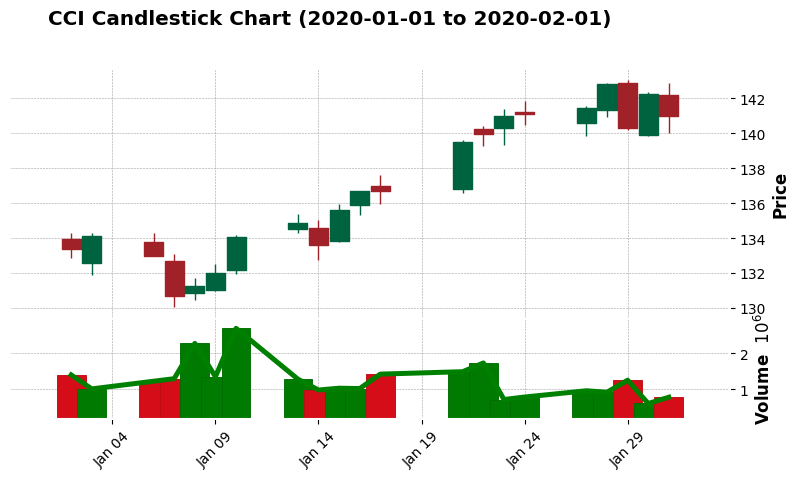

In [55]:
plot_candlesticks(random_stock_dfs_dict, start_date, end_date, freq = 'D')

### Q1d. Observations <a id="q1d"></a>
> Note down your observations, e.g. are there any data issues, unexpected jumps,
unexpected missing data etc.


Let us compare the stock prices of the two companies, namely, `Apple` and `Amazon`. We will plot the closing price of the two companies on the same graph.

In [59]:
stocks = ['AAPL','AMZN']
df_dict = create_df_dict(stocks)
latest_df_dict = get_latest_df_dict(df_dict, years_to_keep)
df_dict = process_df_dict(latest_df_dict)                           # renamed again to df_dict for consistency

In [62]:
print(f"Stock: {stocks[0]}")
df_dict[stocks[0]]              # Dataframe for 'AAPL'

Stock: AAPL


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,15.9429,15.9575,15.9365,15.9406,5096196
1035635,2012-02-27 09:31:00,15.9438,15.9554,15.9059,15.9093,3473680
1035636,2012-02-27 09:32:00,15.9096,15.9625,15.9093,15.9564,2646364
1035637,2012-02-27 09:33:00,15.9503,15.9695,15.9368,15.9486,3405192
1035638,2012-02-27 09:34:00,15.9513,15.9518,15.9334,15.9334,1566936
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,164.8711,164.9100,164.7600,164.8250,291553
2743295,2022-02-25 15:57:00,164.8400,164.8400,164.6500,164.7800,377280
2743296,2022-02-25 15:58:00,164.7900,164.8600,164.7500,164.8300,499079
2743297,2022-02-25 15:59:00,164.8300,164.9100,164.5900,164.8700,1056592


In [63]:
print(f"Stock: {stocks[1]}")
df_dict[stocks[1]]              # Dataframe for 'AAPL'

Stock: AMZN


,DateTime,Open,High,Low,Close,Volume
813782,2012-02-27 09:30:00,177.540,177.7800,177.000,177.2600,75075
813783,2012-02-27 09:31:00,177.270,177.3900,176.500,176.6500,70624
813784,2012-02-27 09:32:00,176.820,177.3000,176.650,177.0600,28645
813785,2012-02-27 09:33:00,177.078,177.6000,177.000,177.2100,57914
813786,2012-02-27 09:34:00,177.220,177.5020,177.002,177.1000,24509
...,...,...,...,...,...,...
2001705,2022-02-25 15:56:00,3072.470,3074.3900,3071.010,3074.0276,6576
2001706,2022-02-25 15:57:00,3074.000,3074.1574,3071.760,3072.5600,9870
2001707,2022-02-25 15:58:00,3073.330,3075.0000,3072.610,3074.4300,14548
2001708,2022-02-25 15:59:00,3074.720,3076.7100,3072.660,3076.7100,34904


We can note that for 'AMZN' stock, in the later years the 'Open' , 'High' , 'Low' and 'Close' prices are a lot more compared to that of 'AAPL' 

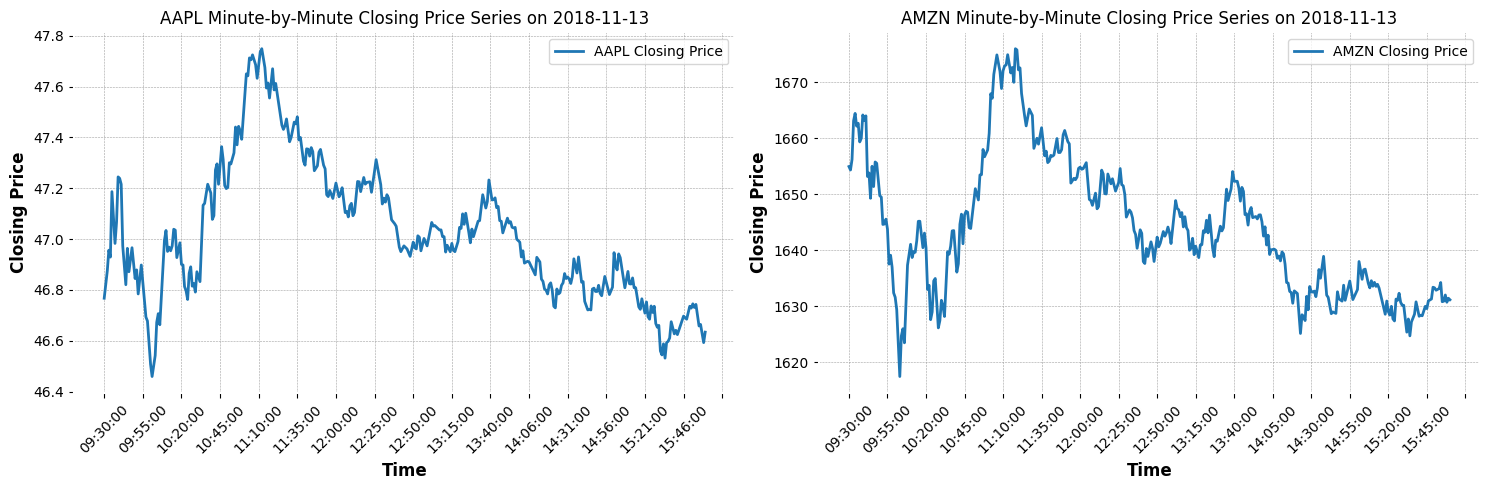

In [64]:
random_date = getrandomdate(df_dict)             # Getting a random date for the two stocks
plot_minute_by_minute(df_dict, random_date)

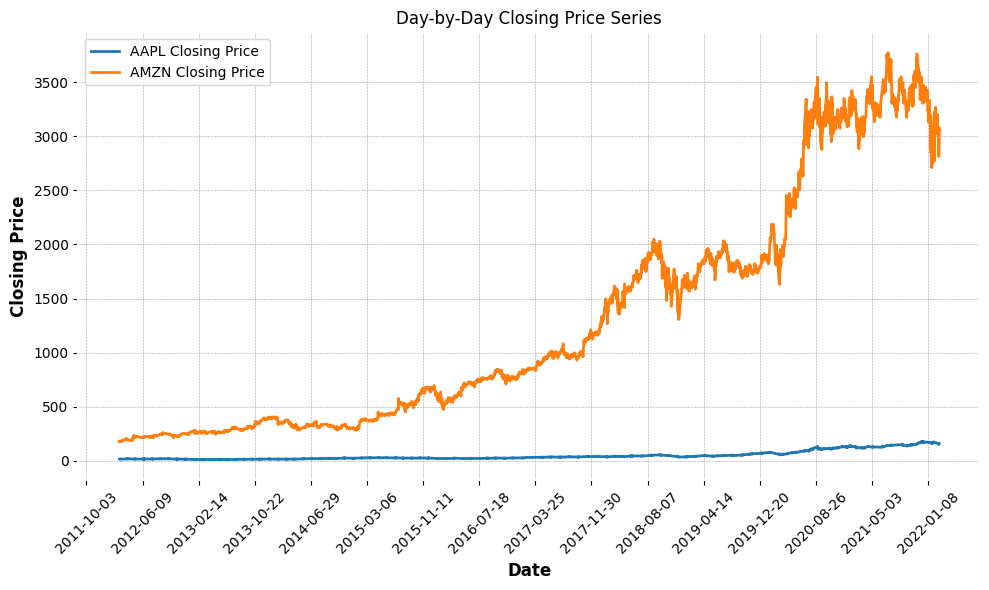

In [65]:
plot_day_by_day_CP(df_dict, combine_plots=True)             # Making a combined plot for the two stocks

Clearly the closing price of 'AMZN' is a lot more than that of 'AAPL' in the later years. We can see almost a flat line in case of 'AAPL' in the later years.

In [11]:
def analyse_stocks(stocks, disp_df = False, plot = False):
    df_dict = create_df_dict(stocks)
    latest_df_dict = get_latest_df_dict(df_dict, years_to_keep)
    df_dict = process_df_dict(latest_df_dict)
    if disp_df:
        for stock in stocks:
            print(f"Stock: {stock}")
            display(df_dict[stock])
    if plot:
        plot_day_by_day_CP(df_dict, combine_plots=True)

Stock: DLX


,DateTime,Open,High,Low,Close,Volume
594550,2012-02-27 09:30:00,19.4221,19.4221,19.3372,19.3488,5106
594551,2012-02-27 09:31:00,19.3835,19.3835,19.3334,19.3527,600
594552,2012-02-27 09:32:00,19.3913,19.3990,19.3758,19.3758,621
594553,2012-02-27 09:33:00,19.3758,19.3913,19.3527,19.3604,500
594554,2012-02-27 09:34:00,19.3449,19.3720,19.3449,19.3720,400
...,...,...,...,...,...,...
1259488,2022-02-25 15:56:00,31.3600,31.3600,31.3300,31.3500,1100
1259489,2022-02-25 15:57:00,31.3400,31.3400,31.2900,31.2900,1437
1259490,2022-02-25 15:58:00,31.3050,31.3400,31.3050,31.3400,2021
1259491,2022-02-25 15:59:00,31.3800,31.3900,31.3400,31.3400,3047


Stock: DLTR


,DateTime,Open,High,Low,Close,Volume
478061,2012-02-27 09:30:00,43.775,43.850,43.690,43.780,36842
478062,2012-02-27 09:31:00,43.790,43.795,43.500,43.545,16508
478063,2012-02-27 09:32:00,43.535,43.605,43.505,43.560,10180
478064,2012-02-27 09:33:00,43.565,43.650,43.565,43.625,7114
478065,2012-02-27 09:34:00,43.625,43.680,43.625,43.660,2100
...,...,...,...,...,...,...
1469376,2022-02-25 15:56:00,140.585,140.670,140.500,140.600,16976
1469377,2022-02-25 15:57:00,140.570,140.590,140.350,140.380,23024
1469378,2022-02-25 15:58:00,140.410,140.510,140.360,140.490,23577
1469379,2022-02-25 15:59:00,140.470,140.750,140.470,140.690,38351


Stock: DFS


,DateTime,Open,High,Low,Close,Volume
466498,2012-02-27 09:30:00,24.7046,24.7375,24.5646,24.6387,62375
466499,2012-02-27 09:31:00,24.6305,24.7128,24.6305,24.6964,21225
466500,2012-02-27 09:32:00,24.6881,24.7622,24.6799,24.6964,26754
466501,2012-02-27 09:33:00,24.6964,24.7869,24.6717,24.7087,26437
466502,2012-02-27 09:34:00,24.6964,24.7227,24.6799,24.6881,19827
...,...,...,...,...,...,...
1455034,2022-02-25 15:56:00,123.8600,123.9700,123.7460,123.8500,16059
1455035,2022-02-25 15:57:00,123.8800,123.8900,123.7500,123.8500,20561
1455036,2022-02-25 15:58:00,123.8500,123.8900,123.7900,123.8150,21752
1455037,2022-02-25 15:59:00,123.8200,124.0200,123.8200,124.0000,51070


Stock: CLX


,DateTime,Open,High,Low,Close,Volume
780555,2012-02-27 09:30:00,51.3502,51.3730,51.3502,51.3730,12116
780556,2012-02-27 09:31:00,51.3882,51.4491,51.3730,51.3730,2321
780557,2012-02-27 09:32:00,51.3502,51.3730,51.3198,51.3198,3300
780558,2012-02-27 09:33:00,51.3045,51.3045,51.3045,51.3045,200
780559,2012-02-27 09:34:00,51.3350,51.4263,51.3274,51.3502,1976
...,...,...,...,...,...,...
1723175,2022-02-25 15:56:00,147.4550,147.6000,147.4200,147.6000,12552
1723176,2022-02-25 15:57:00,147.5600,147.6400,147.4900,147.6100,22249
1723177,2022-02-25 15:58:00,147.6100,147.6400,147.5400,147.5750,20727
1723178,2022-02-25 15:59:00,147.5600,147.6600,147.5600,147.5700,22784


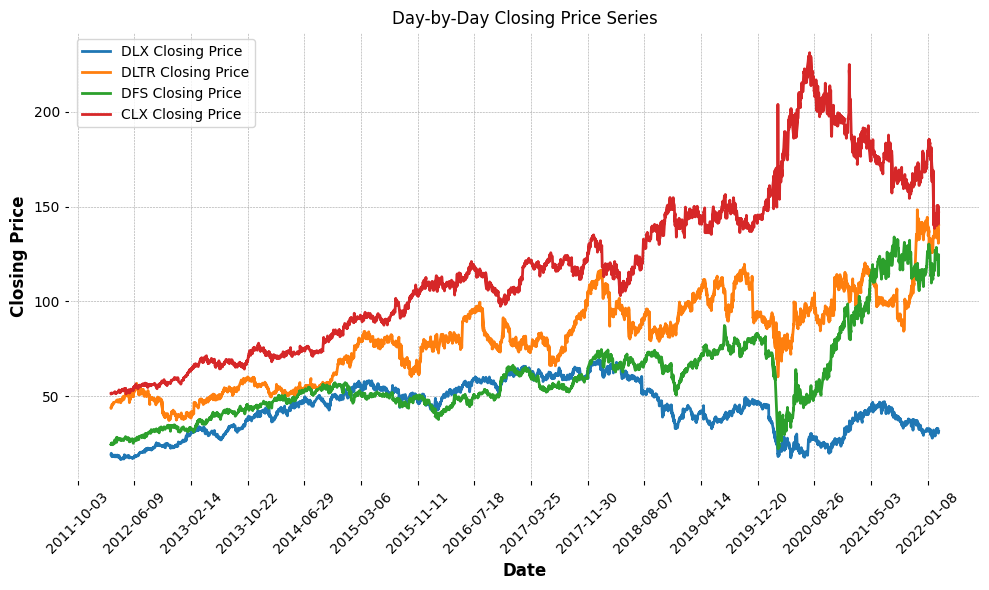

In [71]:
analyse_stocks(['DLX','DLTR','DFS','CLX'], disp_df = True, plot = True)     # just pass the list of stocks to analyse

### Q2. Normalising Data <a id="q2"></a>
> Try at least two ways to normalize the data as stock prices and volumes change over time and are
different across companies, and pick one by noting your justification.

> <span style="font-size: 20px;">Min-Max scaling</span> <a id="MMS"></a>

The `Min-Max scaling` scaling that I have used here scales the data for all the columns: 'Open', 'High', 'Low', 'Close', 'Volume' in the range [-1, 1]. The formula for `Min-Max scaling` is as follows (reference [[5]](#references)):

$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

In [72]:
def min_max_scaler(df_dict):
    scaled_dict = {}
    for stock, df in df_dict.items():
        scaler = MinMaxScaler(feature_range=(-1, 1))               # Create a MinMaxScaler object
        scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close','Volume']]) # Scale the OHLC columns
        scaled_df = df.copy()                                       # Create a copy of the original dataframe
        scaled_df[['Open', 'High', 'Low', 'Close','Volume']] = scaled_data   # Assign scaled values to OHLC columns
        scaled_dict[stock] = scaled_df
    return scaled_dict

In [77]:
scaled_df_dict_MMS = min_max_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
scaled_df_dict_MMS['AMZN']                              # Printing the scaled dataframe for 'AMZN'

Scaled Dataframe for AMZN:


,DateTime,Open,High,Low,Close,Volume,Date,Time
813782,2012-02-27 09:30:00,-0.999533,-0.999533,-0.999722,-0.999661,-0.946142,2012-02-27,09:30:00
813783,2012-02-27 09:31:00,-0.999683,-0.999750,-1.000000,-1.000000,-0.949366,2012-02-27,09:31:00
813784,2012-02-27 09:32:00,-0.999933,-0.999800,-0.999917,-0.999772,-0.979770,2012-02-27,09:32:00
813785,2012-02-27 09:33:00,-0.999790,-0.999633,-0.999722,-0.999689,-0.958571,2012-02-27,09:33:00
813786,2012-02-27 09:34:00,-0.999711,-0.999687,-0.999721,-0.999750,-0.982765,2012-02-27,09:34:00
...,...,...,...,...,...,...,...,...
2001705,2022-02-25 15:56:00,0.610864,0.611423,0.610407,0.611602,-0.995754,2022-02-25,15:56:00
2001706,2022-02-25 15:57:00,0.611715,0.611294,0.610825,0.610785,-0.993368,2022-02-25,15:57:00
2001707,2022-02-25 15:58:00,0.611343,0.611762,0.611298,0.611825,-0.989980,2022-02-25,15:58:00
2001708,2022-02-25 15:59:00,0.612116,0.612713,0.611325,0.613094,-0.975237,2022-02-25,15:59:00


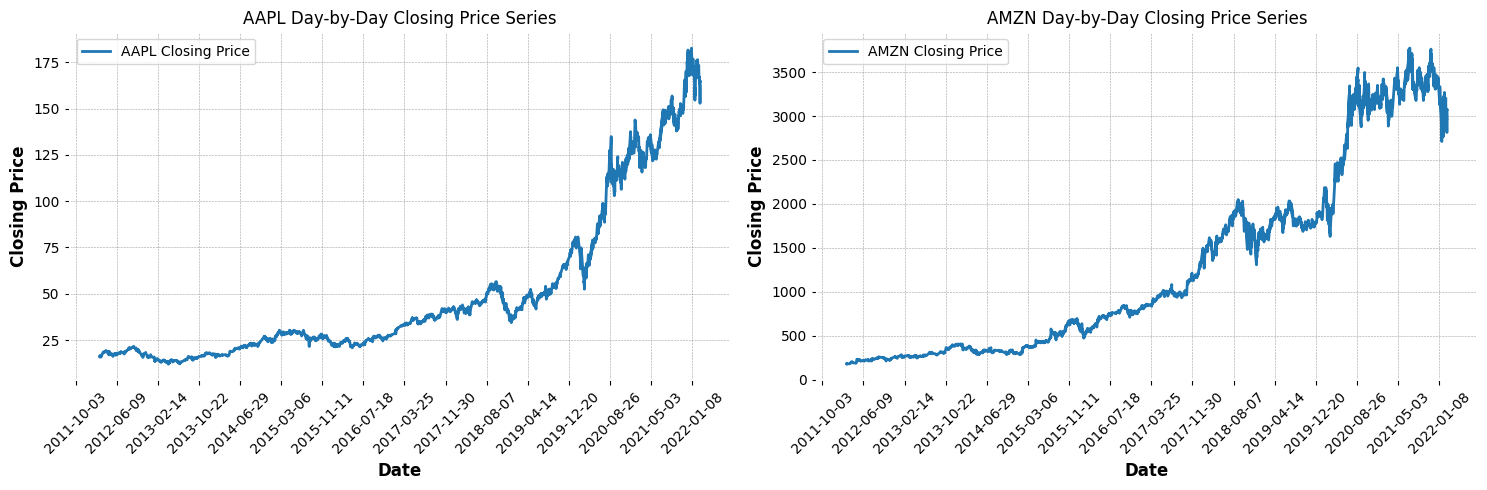

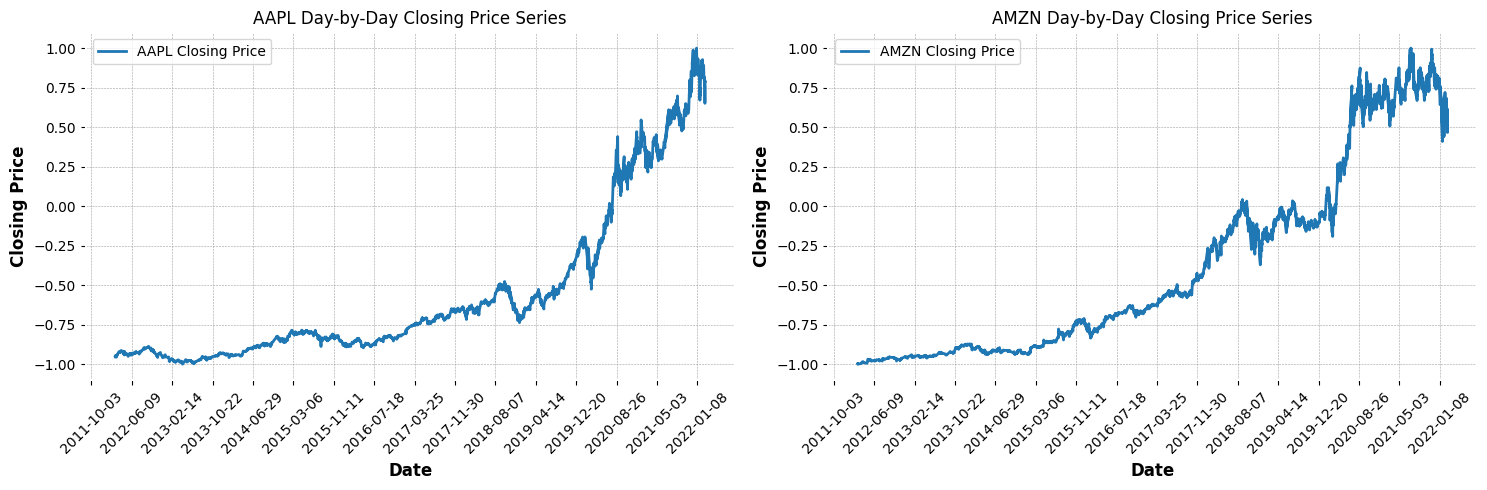

In [78]:
plot_day_by_day_CP(df_dict, combine_plots=False)
plot_day_by_day_CP(scaled_df_dict_MMS, combine_plots=False)

We can notice that `Min-Max Scaling` ensures that all values have the same scale which is [-1,1] without distorting differences in the ranges of values. This is very helpful for LSTM models, as LSTMs are sensitive to the scale of input data. 

> <span style="font-size: 20px;">Z-Score Normalisation</span> <a id="ZSN"></a>

`Z-Score Scaling`, centers and scales the data based on the mean ($ \mu $) and standard deviation ($ \sigma $). The transformation is defined as (reference [[5]](#ref5)):
$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$

In [79]:
def z_score_scaler(df_dict):
    scaled_dict = {}
    for stock, df in df_dict.items():
        scaler = StandardScaler()                                   # Z-Score normalization
        scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close','Volume']])  # Scale the OHLC columns
        scaled_df = df.copy()                                       # Create a copy of the original dataframe
        scaled_df[['Open', 'High', 'Low', 'Close','Volume']] = scaled_data   # Assign scaled values to OHLC columns
        scaled_dict[stock] = scaled_df
    return scaled_dict

In [80]:
scaled_df_dict_ZSN = z_score_scaler(df_dict)
print(f"Scaled Dataframe for AMZN:")
scaled_df_dict_ZSN['AMZN']                            

Scaled Dataframe for AMZN:


,DateTime,Open,High,Low,Close,Volume,Date,Time
813782,2012-02-27 09:30:00,-1.038383,-1.038216,-1.038836,-1.038650,4.266123,2012-02-27,09:30:00
813783,2012-02-27 09:31:00,-1.038641,-1.038588,-1.039313,-1.039232,3.981264,2012-02-27,09:31:00
813784,2012-02-27 09:32:00,-1.039070,-1.038674,-1.039170,-1.038841,1.294654,2012-02-27,09:32:00
813785,2012-02-27 09:33:00,-1.038824,-1.038388,-1.038836,-1.038698,3.167838,2012-02-27,09:33:00
813786,2012-02-27 09:34:00,-1.038688,-1.038481,-1.038834,-1.038802,1.029955,2012-02-27,09:34:00
...,...,...,...,...,...,...,...,...
2001705,2022-02-25 15:56:00,1.724646,1.725097,1.724665,1.726149,-0.117738,2022-02-25,15:56:00
2001706,2022-02-25 15:57:00,1.726106,1.724876,1.725382,1.724749,0.093075,2022-02-25,15:57:00
2001707,2022-02-25 15:58:00,1.725467,1.725679,1.726193,1.726534,0.392462,2022-02-25,15:58:00
2001708,2022-02-25 15:59:00,1.726793,1.727311,1.726241,1.728710,1.695223,2022-02-25,15:59:00


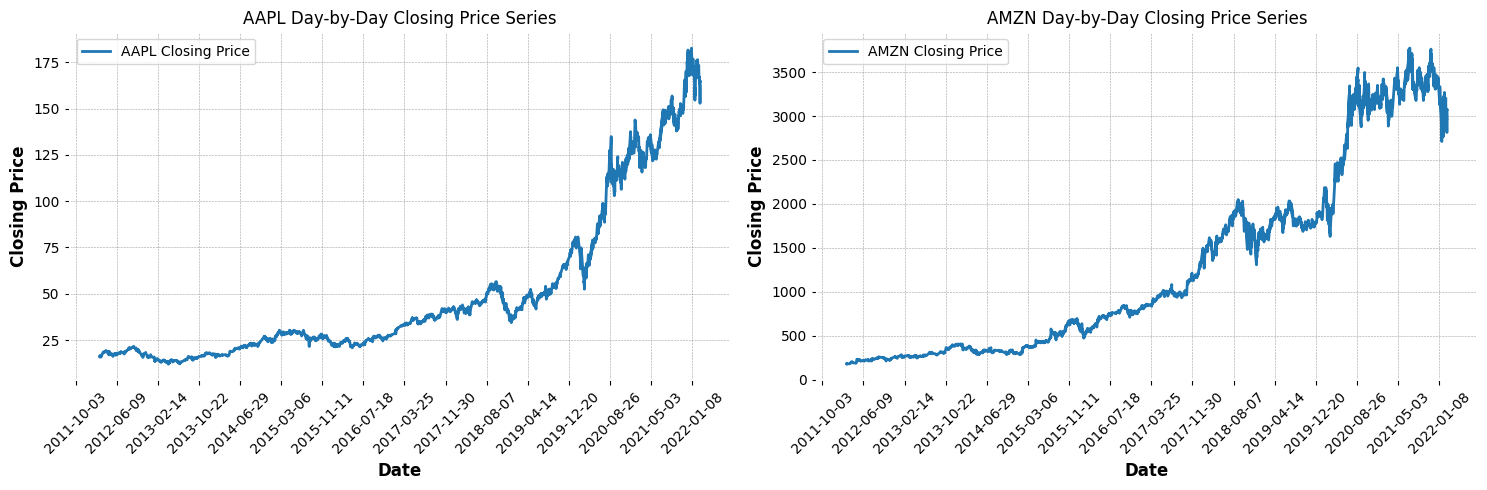

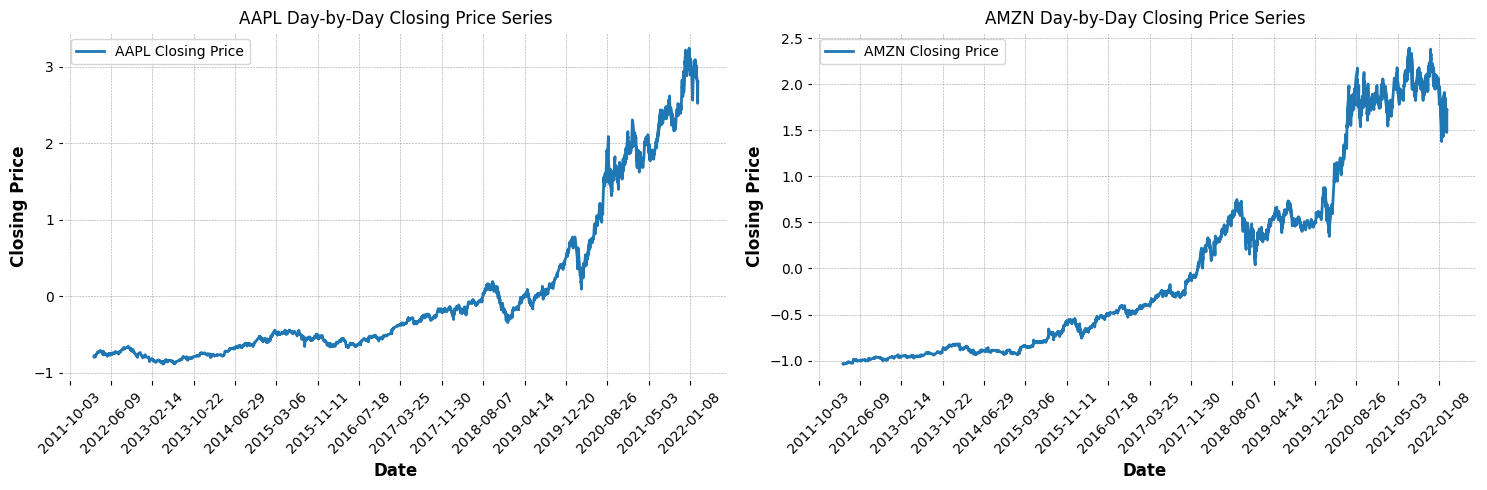

In [81]:
plot_day_by_day_CP(df_dict, combine_plots=False)
plot_day_by_day_CP(scaled_df_dict_ZSN, combine_plots=False)

Since histograms plots are more suitable to visualise the scaling results after Z-Score Normalisation, I have plotted the histograms for the two companies, namely, `Apple` and `Amazon` for the columns: 'Open', 'High', 'Low', 'Close', 'Volume' before and after Z-Score Normalisation.

In [12]:
def plot_histograms(dfs_dict, column='Close'):
    # Determine the number of plots required
    stocks = list(dfs_dict.keys())
    n_stocks = len(dfs_dict)
    nrows = (n_stocks + 1) // 2  # Calculate the number of rows needed for the given stocks
    
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))
    axes = axes.ravel()
    
    for i, stock in enumerate(stocks):    
        ax = axes[i]
        sns.histplot(dfs_dict[stock][column], bins=20, kde=True, ax=ax, label=f'{stock}-{column} Distribution')
        ax.set_title(f'{stock} - {column} Distribution') 
        ax.set_xlabel(f'{column} Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True)

    if n_stocks % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

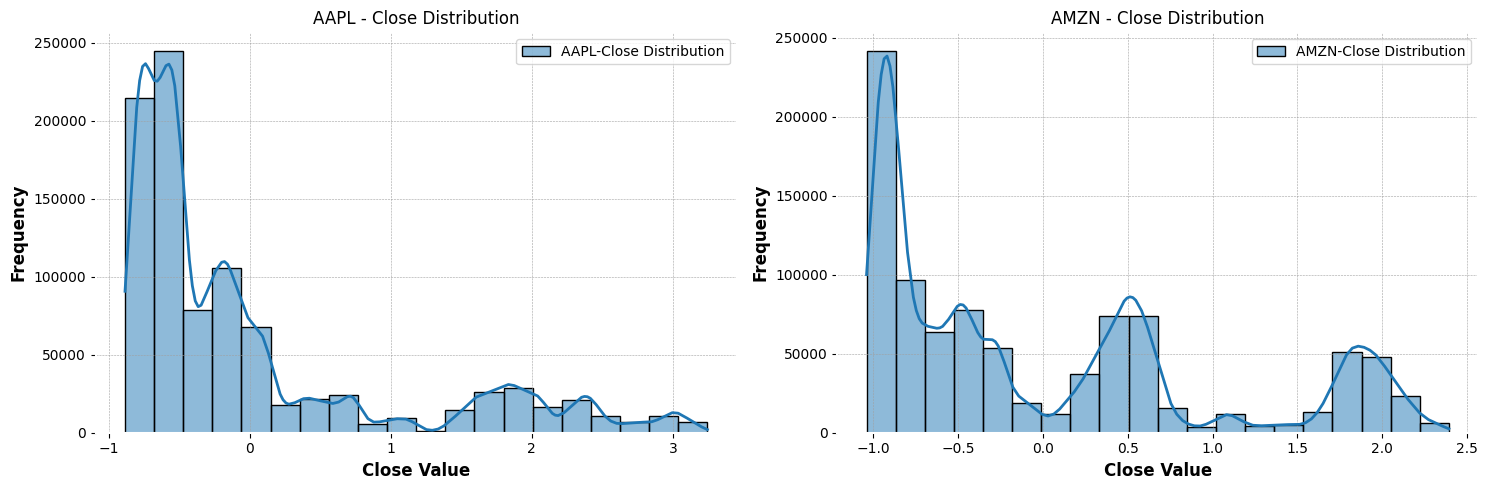

In [89]:
plot_histograms(scaled_df_dict_ZSN, column='Close')

We can see that the distribution of the closing price is not Gaussian. This is because the closing price is not stationary. Hence I think that `Z-Score Scaling` is not a good choice for normalising the data.

> <span style="font-size: 20px;">Percentage Change Scaling</span> <a id="PCS"></a>

The `Percentage Change Scaling` computes the relative change between a value and its preceding value. For a series $ X $ with values $ X_1, X_2, \dots, X_n $, the percentage change for $ X_t $ is:

$$
\text{Percentage Change} = \frac{X_t - X_{t-1}}{X_{t-1}} \times 100
$$

This method is particularly useful for comparing the price movements of different stocks, as it puts the changes in stock prices on a relative scale, independent of the stock’s actual price level. (reference [[5]](#references)) Hence, for the time being I am not using this method for scaling the data.

In [91]:
def percentage_change_scaler(dfs_dict):
    scaled_dfs_dict = {}
    
    for stock, df in dfs_dict.items():
        scaled_df = df.copy()
        
        # Compute percentage change for OHLC columns
        for column in ['Open', 'High', 'Low', 'Close','Volume']:
            scaled_df[column] = df[column].pct_change() * 100
        scaled_df = scaled_df.dropna()                  # Drop the first row with NaN values
        scaled_dfs_dict[stock] = scaled_df
        
    return scaled_dfs_dict

In [94]:
scaled_df_dict_PCS = percentage_change_scaler(df_dict)

One important point to note is that the percentage change for the first data point is always `NaN` as there is no preceding value to compare with. Hence, I have dropped the first row after computing the percentage change.

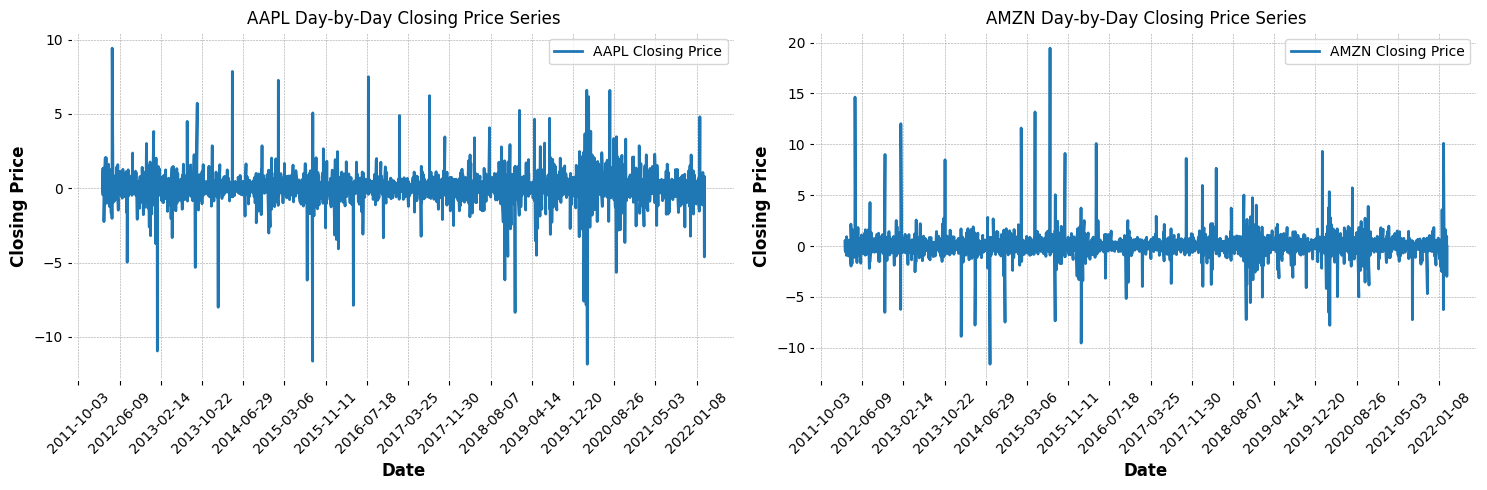

In [96]:
plot_day_by_day_CP(scaled_df_dict_PCS, combine_plots=False)

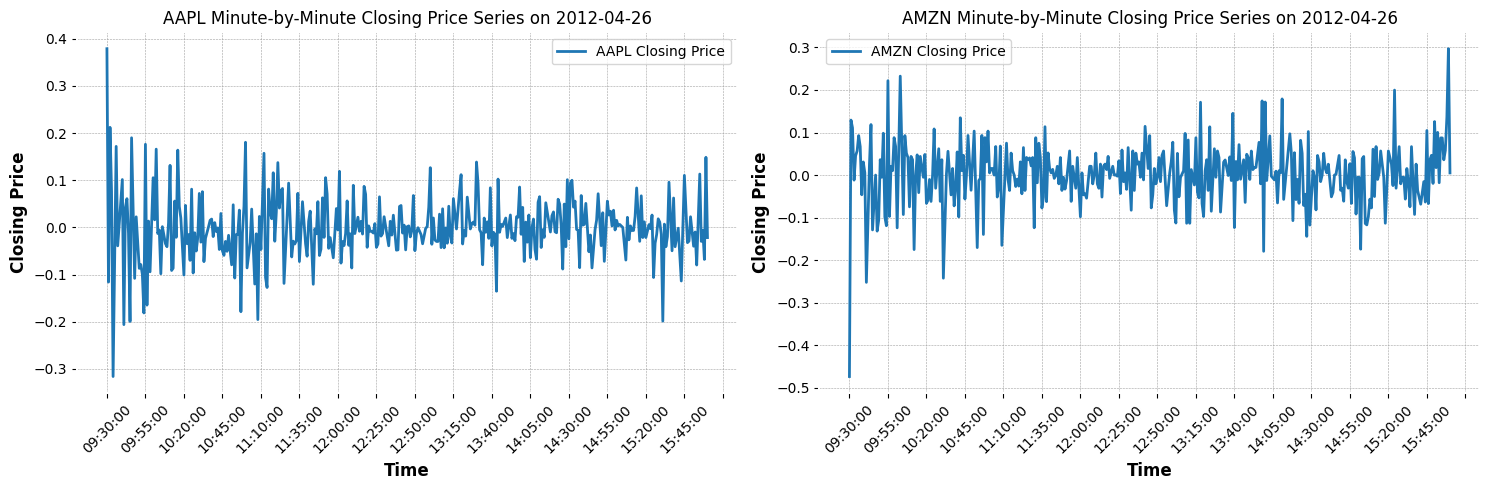

In [97]:
random_date = getrandomdate(scaled_df_dict_PCS)             # Getting a random date for the two stocks
plot_minute_by_minute(scaled_df_dict_PCS, random_date)

> <span style="font-size: 20px;">Log Returns Scaling</span> <a id="LRS"></a>

The log return for a series $ X $ with values $ X_1, X_2, \dots, X_n $ is:

$$
\text{Log Return} = \log \left( \frac{X_t}{X_{t-1}} \right)
$$

This method can help stabilize the variances across time, especially if the stock prices exhibit exponential growth or decay. Log returns also have the property of time-additivity, which is valuable for time series forecasting. (reference [[5]](#references)) Hence, for the time being I am not using this method for scaling the data.

In [99]:
def log_return_scaler(df_dict):
    scaled_dict = {}
    
    for stock, df in df_dict.items():
        scaled_df = df.copy()
        
        # Compute log return for OHLC columns
        for column in ['Open', 'High', 'Low', 'Close','Volume']:            # volume column also
            scaled_df[column] = np.log(df[column] / df[column].shift(1))
        scaled_df = scaled_df.dropna()                  # Drop the first row with NaN values
        scaled_dict[stock] = scaled_df
        
    return scaled_dict

In [100]:
scaled_df_dict_LRS = log_return_scaler(df_dict)

Similar to Percentage Change Scaling, the first row of Dataframe will result in a `NaN` value due to the absence of a previous data point for calculation, so I have dropped it.

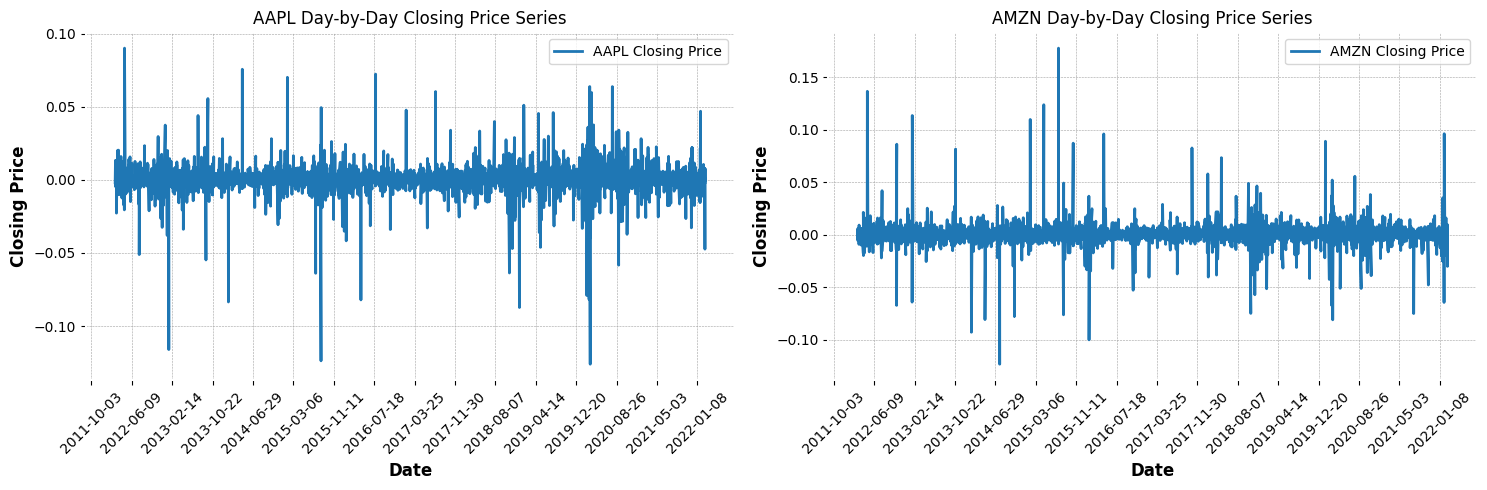

In [101]:
plot_day_by_day_CP(scaled_df_dict_LRS, combine_plots=False)

Given the explanations and observations above, it seems that `Min Max Scaling` is best suited for the LSTM model. This is primarily because LSTMs benefit from consistent and scaled input data, ensuring that all features contribute equally to the model's learning process. `Min Max Scaling` also avoids potential issues arising from non-normal distributions or skewness in the data. Hence I have used `Min Max Scaling` for scaling the data from now onwards.

### Q3. Scenarios <a id="q3"></a>
> Make some Scenario decisions:
#### Q3a. Trading Strategies <a id="q3a"></a>
> high-frequency trading or intra-day swing, or inter-day trade, or long-term (multi-day or
multi-week or multi-month).


> <span style="font-size: 20px;">Intra-day Swing Trading</span> <a id="MMS"></a>

Let us pick up some stocks that belong to same industry. 'AAPL', 'ADBE', 'AMZN' and 'AMD'- let us pick these for our analysis.

Stock: AAPL


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,15.9429,15.9575,15.9365,15.9406,5096196
1035635,2012-02-27 09:31:00,15.9438,15.9554,15.9059,15.9093,3473680
1035636,2012-02-27 09:32:00,15.9096,15.9625,15.9093,15.9564,2646364
1035637,2012-02-27 09:33:00,15.9503,15.9695,15.9368,15.9486,3405192
1035638,2012-02-27 09:34:00,15.9513,15.9518,15.9334,15.9334,1566936
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,164.8711,164.9100,164.7600,164.8250,291553
2743295,2022-02-25 15:57:00,164.8400,164.8400,164.6500,164.7800,377280
2743296,2022-02-25 15:58:00,164.7900,164.8600,164.7500,164.8300,499079
2743297,2022-02-25 15:59:00,164.8300,164.9100,164.5900,164.8700,1056592


Stock: ADBE


,DateTime,Open,High,Low,Close,Volume
737378,2012-02-27 09:30:00,33.180,33.250,33.09,33.250,48552
737379,2012-02-27 09:31:00,33.235,33.240,33.20,33.220,14524
737380,2012-02-27 09:32:00,33.250,33.250,33.21,33.210,20160
737381,2012-02-27 09:33:00,33.210,33.210,33.15,33.155,10249
737382,2012-02-27 09:34:00,33.156,33.200,33.15,33.190,6920
...,...,...,...,...,...,...
1756310,2022-02-25 15:56:00,465.570,465.730,464.90,464.935,9822
1756311,2022-02-25 15:57:00,464.850,464.945,464.50,464.660,8188
1756312,2022-02-25 15:58:00,464.720,465.075,464.72,464.960,20844
1756313,2022-02-25 15:59:00,465.020,465.530,464.93,465.500,38153


Stock: AMD


,DateTime,Open,High,Low,Close,Volume
797096,2012-02-27 09:30:00,7.38,7.40,7.370,7.380,177695
797097,2012-02-27 09:31:00,7.39,7.39,7.320,7.350,44382
797098,2012-02-27 09:32:00,7.34,7.35,7.290,7.290,115104
797099,2012-02-27 09:33:00,7.29,7.30,7.280,7.290,57314
797100,2012-02-27 09:34:00,7.29,7.30,7.285,7.295,12850
...,...,...,...,...,...,...
2246092,2022-02-25 15:56:00,121.10,121.15,120.970,121.050,257373
2246093,2022-02-25 15:57:00,121.05,121.06,120.810,120.880,259472
2246094,2022-02-25 15:58:00,120.90,121.06,120.890,121.020,263317
2246095,2022-02-25 15:59:00,121.01,121.16,120.980,121.070,601523


Stock: CSCO


,DateTime,Open,High,Low,Close,Volume
994112,2012-02-27 09:30:00,14.7836,14.8316,14.7614,14.8205,655032
994113,2012-02-27 09:31:00,14.8205,14.8353,14.7762,14.7836,249664
994114,2012-02-27 09:32:00,14.7836,14.8205,14.7762,14.7983,256853
994115,2012-02-27 09:33:00,14.8020,14.8131,14.7688,14.7688,177228
994116,2012-02-27 09:34:00,14.7725,14.7836,14.7688,14.7762,65224
...,...,...,...,...,...,...
2132465,2022-02-25 15:56:00,56.0150,56.0400,55.9910,56.0200,118400
2132466,2022-02-25 15:57:00,56.0250,56.0250,55.9750,55.9850,119684
2132467,2022-02-25 15:58:00,55.9800,56.0350,55.9800,56.0350,168133
2132468,2022-02-25 15:59:00,56.0300,56.0800,56.0200,56.0450,425762


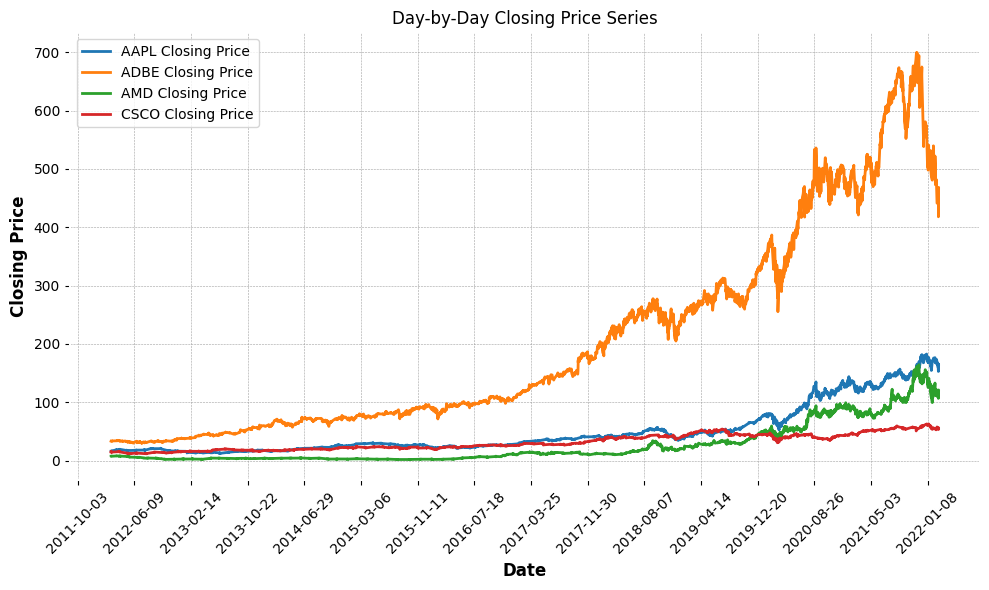

In [105]:
analyse_stocks(['AAPL', 'ADBE', 'AMD','CSCO'], disp_df = True, plot = True)

#### Q3b. Buy-Ask Spread<a id="q3b"></a>
> Assume a buy-ask spread (inversely related to volume and directly related to price) and trade commission based on a quick market research. Your trade will lose the buy-ask spread and commissions every time you trade.

Based on the quick market research (reference [[15]](#references) and [[16]](#references)), I was able to find bid-ask spread of technology sector stocks (which I will be mainly using for analysis) to be typically ranging from 0.01% to 0.05%. Hence, I have assumed the bid-ask spread to be `0.02%` for the time being.

Since I will be mainly using Apple Inc. stock for analysis, For 'AAPL', based on reference [[15]](#references), the bid was: 189.20 x 1000 means that there are 1000 shares available for purchase at the bid price of $189.20 and ask was: "189.30 x 800" means that there are 800 shares being offered for sale at the ask price of $189.30. Hence, the bid-ask spread is 0.1 USD (0.05 spread percentage) for 'AAPL'. 

For simplicity, I have assumed the trade commission to be `2 USD` for the time being.

#### Q3c. Trading Frequency <a id="q3c"></a>
> Decide if you will trade only one stock, or have a model to trade a basket from a particular
industry, or any stock.

### Working with Single Stock <a id="single-stock"></a>
For simplicty, let us now work with only one stock, namely, `Apple`.

In [13]:
stocks = ['AAPL']
df_dict = create_df_dict(stocks)
latest_df_dict = get_latest_df_dict(df_dict, years_to_keep)
df_dict = process_df_dict(latest_df_dict)                   # renamed again to df_dict for consistency

In [15]:
print(f"Dataframe for '{stocks[0]}':")
df_dict[stocks[0]]

Dataframe for 'AAPL':


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,15.9429,15.9575,15.9365,15.9406,5096196
1035635,2012-02-27 09:31:00,15.9438,15.9554,15.9059,15.9093,3473680
1035636,2012-02-27 09:32:00,15.9096,15.9625,15.9093,15.9564,2646364
1035637,2012-02-27 09:33:00,15.9503,15.9695,15.9368,15.9486,3405192
1035638,2012-02-27 09:34:00,15.9513,15.9518,15.9334,15.9334,1566936
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,164.8711,164.9100,164.7600,164.8250,291553
2743295,2022-02-25 15:57:00,164.8400,164.8400,164.6500,164.7800,377280
2743296,2022-02-25 15:58:00,164.7900,164.8600,164.7500,164.8300,499079
2743297,2022-02-25 15:59:00,164.8300,164.9100,164.5900,164.8700,1056592


Since I have chosen Min-Max Scaling, let us make a function `scale_df_dict` that will scale the dataframe for each stock in `df_dict` and store it in `scaled_df_dict`.

In [14]:
def scale_df_dict(df_dict):
    """
    Applies Min-Max Scaling and Scales the data in each dataframe between -1 and 1.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - scaled_df_dict, scalers_dict (tuple): A tuple containing the scaled dataframes dictionary and a dictionary of scalers used for each column.
    """
    scaled_df_dict = {}
    scalers_dict = {}
    for stock, df in df_dict.items():
        scaled_df = pd.DataFrame()
        scaled_df['DateTime'] = df['DateTime']
        cols = list(df)[1:]
        for col in cols:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaled_df[col] = scaler.fit_transform(df[[col]].astype(float))
            scalers_dict[(stock, col)] = scaler
        scaled_df_dict[stock] = scaled_df
        
    return scaled_df_dict, scalers_dict

In [17]:
scaled_df_dict, scalers_dict = scale_df_dict(df_dict)

In [18]:
print(f"Dataframe for '{stocks[0]}' (Scaled):")
scaled_df_dict[stocks[0]]

Dataframe for 'AAPL' (Scaled):


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,-0.953561,-0.953552,-0.953277,-0.953580,-0.937767
1035635,2012-02-27 09:31:00,-0.953551,-0.953576,-0.953635,-0.953947,-0.957825
1035636,2012-02-27 09:32:00,-0.953951,-0.953493,-0.953596,-0.953395,-0.968052
1035637,2012-02-27 09:33:00,-0.953474,-0.953411,-0.953273,-0.953486,-0.958671
1035638,2012-02-27 09:34:00,-0.953463,-0.953618,-0.953313,-0.953664,-0.981395
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,0.791948,0.791497,0.791781,0.791408,-0.997162
2743295,2022-02-25 15:57:00,0.791583,0.790677,0.790491,0.790881,-0.996102
2743296,2022-02-25 15:58:00,0.790997,0.790912,0.791664,0.791467,-0.994596
2743297,2022-02-25 15:59:00,0.791466,0.791497,0.789788,0.791936,-0.987704


In [15]:
def train_test_df_split(df_dict):
    """
    Splits each dataframe into training, validation, and test sets.
    
    Parameters:
    - df_dict (dict): Dictionary containing stock dataframes.
    
    Returns:
    - train_df_dict, valid_df_dict, test_df_dict (tuple): A tuple containing dictionaries for training, validation, and test data for each stock.
    """    
    train_df_dict = {}
    valid_df_dict = {}
    test_df_dict = {}
    for stock, df in df_dict.items():
        df['DateTime'] = pd.to_datetime(df['DateTime'])  # Ensure the DateTime column is of datetime type

        # Find the date that is two years before the last date in the dataframe
        offset_date = df['DateTime'].iloc[-1] - pd.DateOffset(years=2)

        # Separate out the last two years for the test set
        mask = df['DateTime'] >= offset_date
        test_df = df[mask]

        # From the remaining data, split 10% for the validation set
        remaining_df = df[~mask]
        valid_length = int(0.1 * len(remaining_df))
        valid_df = remaining_df[-valid_length:]

        # The rest of the data is for the training set
        train_df = remaining_df[:-valid_length]

        train_df_dict[stock] = train_df
        valid_df_dict[stock] = valid_df
        test_df_dict[stock] = test_df

    return train_df_dict, valid_df_dict, test_df_dict

In [20]:
train_df_dict, valid_df_dict, test_df_dict = train_test_df_split(scaled_df_dict)
print(f"Length of Train Dataframe for {stocks[0]},'Close' Column: {len(train_df_dict[stocks[0]])} ({len(train_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")
print(f"Length of Validation Dataframe for {stocks[0]},'Close' Column: {len(valid_df_dict[stocks[0]])} ({len(valid_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")
print(f"Length of Test Dataframe for {stocks[0]},'Close' Column: {len(test_df_dict[stocks[0]])} ({len(test_df_dict[stocks[0]]) / len(scaled_df_dict[stocks[0]]) * 100:.2f}%)")

Length of Train Dataframe for AAPL,'Close' Column: 674334 (72.27%)
Length of Validation Dataframe for AAPL,'Close' Column: 74925 (8.03%)
Length of Test Dataframe for AAPL,'Close' Column: 183869 (19.70%)


Since the last two years are to be kept for testing, we have `test_df_dict` function with two years of data and from the remaining data we have `valid_df_dict` (10%) and rest is `train_df_dict` (90%) of remaining data.

In [21]:
print(f"'{stocks[0]}' Training Dataframe (Scaled):")
train_df_dict[stocks[0]]

'AAPL' Training Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,-0.953561,-0.953552,-0.953277,-0.953580,-0.937767
1035635,2012-02-27 09:31:00,-0.953551,-0.953576,-0.953635,-0.953947,-0.957825
1035636,2012-02-27 09:32:00,-0.953951,-0.953493,-0.953596,-0.953395,-0.968052
1035637,2012-02-27 09:33:00,-0.953474,-0.953411,-0.953273,-0.953486,-0.958671
1035638,2012-02-27 09:34:00,-0.953463,-0.953618,-0.953313,-0.953664,-0.981395
...,...,...,...,...,...,...
2182095,2019-04-12 11:26:00,-0.578244,-0.578480,-0.577860,-0.578294,-0.997939
2182096,2019-04-12 11:27:00,-0.578349,-0.578553,-0.578059,-0.578251,-0.997006
2182097,2019-04-12 11:28:00,-0.578244,-0.578300,-0.577888,-0.577980,-0.997313
2182098,2019-04-12 11:29:00,-0.577999,-0.577853,-0.577546,-0.577567,-0.997511


In [22]:
print(f"'{stocks[0]}' Validation Dataframe (Scaled):")
valid_df_dict[stocks[0]]

'AAPL' Validation Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
2182100,2019-04-12 11:31:00,-0.577788,-0.577966,-0.577403,-0.577837,-0.998470
2182101,2019-04-12 11:32:00,-0.577844,-0.577995,-0.577528,-0.577752,-0.998317
2182102,2019-04-12 11:33:00,-0.577772,-0.577995,-0.577432,-0.577666,-0.999053
2182103,2019-04-12 11:34:00,-0.577633,-0.577496,-0.577144,-0.577310,-0.996624
2182104,2019-04-12 11:35:00,-0.577302,-0.577567,-0.577118,-0.577610,-0.998198
...,...,...,...,...,...,...
2328744,2020-02-25 15:55:00,-0.307496,-0.307005,-0.308928,-0.306592,-0.992668
2328745,2020-02-25 15:56:00,-0.306568,-0.306976,-0.307887,-0.308297,-0.991070
2328746,2020-02-25 15:57:00,-0.308360,-0.307352,-0.308431,-0.307053,-0.990386
2328747,2020-02-25 15:58:00,-0.307059,-0.307409,-0.307771,-0.306967,-0.990013


In [23]:
print(f"'{stocks[0]}' Test Dataframe (Scaled):")
test_df_dict[stocks[0]]

'AAPL' Test Dataframe (Scaled):


,DateTime,Open,High,Low,Close,Volume
2328749,2020-02-25 16:00:00,-0.307753,-0.307208,-0.307164,-0.306765,-0.844280
2329226,2020-02-26 09:30:00,-0.311857,-0.307843,-0.311675,-0.307632,-0.918646
2329227,2020-02-26 09:31:00,-0.307406,-0.307843,-0.311675,-0.310487,-0.984905
2329228,2020-02-26 09:32:00,-0.310643,-0.304174,-0.310143,-0.303860,-0.982534
2329229,2020-02-26 09:33:00,-0.303677,-0.300736,-0.304127,-0.302487,-0.979499
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,0.791948,0.791497,0.791781,0.791408,-0.997162
2743295,2022-02-25 15:57:00,0.791583,0.790677,0.790491,0.790881,-0.996102
2743296,2022-02-25 15:58:00,0.790997,0.790912,0.791664,0.791467,-0.994596
2743297,2022-02-25 15:59:00,0.791466,0.791497,0.789788,0.791936,-0.987704


The following function works with one DataFrame at a time. 

In [16]:
def df_to_tensors(df, seq_length, pred_horizon, predict = 'Close'): 
    """
    Converts a dataframe into input and target tensors for the LSTM model.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - seq_length (int): Sequence Length for LSTM.
    - pred_horizon (int): Prediction horizon.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    
    Returns:
    - X, Y (tuple): Input and target tensors.
    """
    df = df.drop('DateTime', axis=1)
    df_as_np = np.array(df)
    predict_col_idx = list(df.columns).index(predict)
    X_list, Y_list = [], []
    for i in range(seq_length, len(df_as_np) - pred_horizon +1):
        X_list.append(df_as_np[i - seq_length:i, :df_as_np.shape[1]])
        Y_list.append(df_as_np[i + pred_horizon - 1:i + pred_horizon, predict_col_idx])       
    X_np, Y_np = np.array(X_list), np.array(Y_list)
    X, Y = torch.tensor(X_np, dtype=torch.float32), torch.tensor(Y_np, dtype=torch.float32)   
    return X, Y

In [25]:
X, Y = df_to_tensors(scaled_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

X shape: torch.Size([933118, 10, 5]), Y shape: torch.Size([933118, 1])


$\text{Shape of X: } (\text{Number of Samples} \times \text{Sequence Length} \times \text{Number of Features})$
$\text{Shape of Y: } (\text{Number of Samples} \times 1)$

In [26]:
print(X[0])

tensor([[-0.9536, -0.9536, -0.9533, -0.9536, -0.9378],
        [-0.9536, -0.9536, -0.9536, -0.9539, -0.9578],
        [-0.9540, -0.9535, -0.9536, -0.9534, -0.9681],
        [-0.9535, -0.9534, -0.9533, -0.9535, -0.9587],
        [-0.9535, -0.9536, -0.9533, -0.9537, -0.9814],
        [-0.9537, -0.9538, -0.9535, -0.9537, -0.9710],
        [-0.9537, -0.9537, -0.9534, -0.9537, -0.9752],
        [-0.9537, -0.9538, -0.9535, -0.9537, -0.9762],
        [-0.9538, -0.9539, -0.9536, -0.9538, -0.9773],
        [-0.9538, -0.9539, -0.9535, -0.9538, -0.9880]])


In [27]:
print(X[1])

tensor([[-0.9536, -0.9536, -0.9536, -0.9539, -0.9578],
        [-0.9540, -0.9535, -0.9536, -0.9534, -0.9681],
        [-0.9535, -0.9534, -0.9533, -0.9535, -0.9587],
        [-0.9535, -0.9536, -0.9533, -0.9537, -0.9814],
        [-0.9537, -0.9538, -0.9535, -0.9537, -0.9710],
        [-0.9537, -0.9537, -0.9534, -0.9537, -0.9752],
        [-0.9537, -0.9538, -0.9535, -0.9537, -0.9762],
        [-0.9538, -0.9539, -0.9536, -0.9538, -0.9773],
        [-0.9538, -0.9539, -0.9535, -0.9538, -0.9880],
        [-0.9538, -0.9540, -0.9539, -0.9542, -0.9423]])


In [28]:
print(Y)                        # Y is the next day's closing or opening price depending on predict = 'Close' or 'Open'

tensor([[-0.9542],
        [-0.9545],
        [-0.9550],
        ...,
        [ 0.7915],
        [ 0.7919],
        [ 0.7917]])


In [29]:
X_train, Y_train = df_to_tensors(train_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
X_valid, Y_valid = df_to_tensors(valid_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)
X_test, Y_test = df_to_tensors(test_df_dict[stocks[0]], seq_length=seq_length, pred_horizon=pred_horizon, predict = predict)

In [30]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([674324, 10, 5]), Y_train shape: torch.Size([674324, 1])
X_valid shape: torch.Size([74915, 10, 5]), Y_valid shape: torch.Size([74915, 1])
X_test shape: torch.Size([183859, 10, 5]), Y_test shape: torch.Size([183859, 1])


### Q4. LSTM Model <a id="q4"></a>
> Write a pytorch module for defining an LSTM model. Keep it flexible so that the input dimension,
number of units, number of layers can easily be changed.

In [17]:
# Defining a flexible LSTM model using PyTorch
class LSTM(nn.Module):
    """
    LSTM model for time series forecasting.
    
    Attributes:
    - input_dim (int): Number of input features.
    - hidden_dim (int): Number of hidden units.
    - num_layers (int): Number of LSTM layers.
    - output_dim (int): Number of output dimensions
    """
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        # Hidden dimensions and number of layers
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Pass through the LSTM layers
        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Only take the output from the final time step
        out = self.linear(out[:, -1, :])
        return out

The model is kept flexible so that the input dimension, number of units, number of layers can easily be changed. A temporary LSTM model is defined in the following cell.

In [30]:
model_temp = LSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers, output_dim=Y_train.shape[1])
print(model_temp)

LSTM(
  (lstm): LSTM(5, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


### Q5. DataLoader <a id="q5"></a>
> Write a flexible dataloader for training the LSTM model, especially if you are high frequency data.
The inputs should be open, close, high, low, volume of one or more stocks (e.g. other stocks that can
help predict the chosen stock price).

Code snippet for the following cell is referred from [[11]](#references)

In [18]:
class StockDataset(Dataset):
    """
    Dataset class for stock data.
    """
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [33]:
train_dataset = StockDataset(X_train, Y_train)
valid_dataset = StockDataset(X_valid, Y_valid)
test_dataset = StockDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

For now we are working with single stock namely, `Apple`. Hence, `X_train` contains the data from all the five columns, namely, 'Open', 'High', 'Low', 'Close', 'Volume' for `Apple`.

In [34]:
print(f"Number of training sequences: {len(train_loader.dataset)}")
print(f"Number of validation sequences: {len(valid_loader.dataset)}")
print(f"Number of test sequences: {len(test_loader.dataset)}")  
for X, Y in train_loader:
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    break

Number of training sequences: 674324
Number of validation sequences: 74915
Number of test sequences: 183859
X shape: torch.Size([128, 10, 5]), Y shape: torch.Size([128, 1])


$\text{Shape of X: } (\text{Batch Size} \times \text{Sequence Length} \times \text{Number of Features})$
$\text{Shape of Y: } (\text{Batch Size} \times 1)$

### Q6. Training Loop <a id="q5"></a>
> Train or pre-train the model by trying to predict the future price (or change in price, if normalized)
and keep the future horizon flexible (e.g., easy to change between one minute or 10 minutes into the
future). You can try to predict the opening or closing time. Leave the last two years out for testing.

In [19]:
def train_model(model, stocks, train_loader, valid_loader, num_epochs, learning_rate, regularize, weight_decay, save_best, patience):
    """
    Training Loop function
    
    Parameters:
    - model (LSTM): LSTM model to train.
    - train_loader (DataLoader): Training data loader.
    - valid_loader (DataLoader): Validation data loader.
    - num_epochs (int): Number of epochs for training.
    - learning_rate (float): Learning rate for optimization.
    - regularize (bool): Whether to apply regularization.
    - weight_decay (float): Weight decay for regularization.
    - save_best (bool): Whether to save the best model.
    - patience (int): For early stopping.
    
    Returns:
    - tuple: Trained model, training losses per epoch, and validation losses per epoch.
    """
    # Transfer the model to the device
    model = model.to(device)
    
    # Define the loss function and the optimizer
    criterion = nn.MSELoss()  # Using Mean Squared Error Loss for regression
    if regularize:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
     
    # Lists to store the average loss per epoch for training and validation
    train_losses = []
    valid_losses = []
    
    # Early stopping initialization
    epochs_no_improve = 0
    best_valid_loss = float('inf')
    best_model = None
    
    for epoch in range(1, num_epochs+1):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        # Using tqdm for the training loop to display a progress bar
        pbar = tqdm(train_loader, total=len(train_loader), leave=False)
       
        for _, batch in enumerate(pbar):
            # Transfer sequences and labels to device
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_train_loss += loss.item()
            
            # Backward pass and optimization
            loss.backward()
            
            optimizer.step()
            
            # Update progress bar
            pbar.set_postfix(train_loss=loss.item())
        
        # Average training loss
        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Validation loss
        model.eval()  # Set the model to evaluation mode
        running_valid_loss = 0.0
        for _, batch in enumerate(valid_loader):
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            with torch.no_grad():
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                running_valid_loss += loss.item()
                
        # Average validation loss
        avg_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(avg_valid_loss)
        
        # Early stopping and best model saving logic
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_model = model.state_dict()            
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        # Print epoch details
        print(f'''{"#"*100}
Epoch: [{epoch}/{num_epochs}] | Epoch Train Loss: {avg_train_loss} | Epoch Valid Loss: {avg_valid_loss}
{"#"*100}''')
        
        # Check early stopping condition
        if epochs_no_improve == patience:
            print(f"Early stopping!!, Since validation loss has not improved in the last {patience} epochs.")
            model.load_state_dict(best_model)  # Restore model to the best state
            break
        
    # Save the best model
    if save_best: 
        path = pl.Path("best_models")
        path.mkdir(parents=True, exist_ok=True)
        filename = f"Best_model_stock_{stocks[0]}_epoch_{epoch}_valid_loss_{avg_valid_loss}.pt"
        print(f"{filename} saved in 'best_models' folder...") 
        torch.save(model.state_dict(), path / filename)

    return model, train_losses, valid_losses

### Training model <a id="training-model"></a>

In [72]:
model = LSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers, output_dim=Y_train.shape[1])
trained_model, train_losses, valid_losses = train_model(model, stocks, train_loader, valid_loader, num_epochs=epochs, learning_rate=learning_rate, regularize=regularize, weight_decay=weight_decay, save_best=save_best, patience=patience)

####################################################################################################
Epoch: [1/10] | Epoch Train Loss: 2.2172568253671574e-06 | Epoch Valid Loss: 6.040133790630098e-07
####################################################################################################


####################################################################################################
Epoch: [2/10] | Epoch Train Loss: 8.529701999271473e-08 | Epoch Valid Loss: 1.1534135372208612e-07
####################################################################################################


####################################################################################################
Epoch: [3/10] | Epoch Train Loss: 5.237771344919061e-08 | Epoch Valid Loss: 2.368251824968042e-07
####################################################################################################


####################################################################################################
Epoch: [4/10] | Epoch Train Loss: 3.960988306524385e-08 | Epoch Valid Loss: 5.940386361689736e-07
####################################################################################################


####################################################################################################
Epoch: [5/10] | Epoch Train Loss: 3.0423600941638044e-08 | Epoch Valid Loss: 6.3855871887334e-07
####################################################################################################


####################################################################################################
Epoch: [6/10] | Epoch Train Loss: 2.544343993288042e-08 | Epoch Valid Loss: 7.256793807594348e-07
####################################################################################################
Early stopping!!, Validation loss has not improved in the last 4 epochs.
Best_model_stock_AAPL_epoch_6_valid_loss_7.256793807594348e-07.pt saved in 'best_models' folder...


### Plotting Training and Validation Loss <a id="plotting-training-and-validation-loss"></a>

In [20]:
def plot_losses(train_losses, valid_losses, title):
    """
    Plots training and validation losses per epoch.
    
    Parameters:
    - train_losses (list): Training losses per epoch.
    - valid_losses (list): Validation losses per epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(figsize=(8, 4))
    # Plotting train losses
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
    # Plotting valid losses
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='o', color='red')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

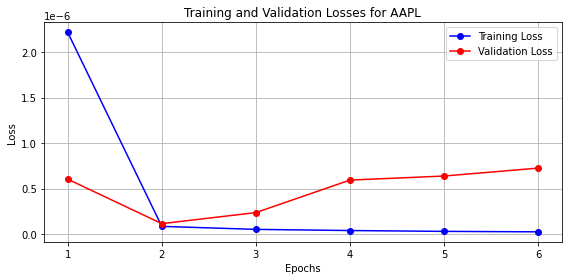

In [73]:
plot_losses(train_losses, valid_losses, title=f"Training and Validation Losses for {stocks[0]}")

The plot above suggest that early stopping might help the model to generalise better.

#### Predictions on Validation Data <a id="predictions-on-validation-data"></a>
Let us first check out predictions on the validation set.

In [74]:
with torch.no_grad():
    Y_valid_pred = trained_model(X_valid.to(device)).to('cpu').numpy()

Here Column = 'Close' or 'Open' whichever is predicted

In [21]:
def descale_data(scaled_data, stock, column, scalers_dict):
    """
    Converts scaled data back to its original scale.
    
    Parameters:
    - scaled_data (array-like): Data that was scaled.
    - stock (str): Name of the stock.
    - column (str, optional): Column name of the data. Defaults to 'Close'.
    - scalers_dict (dict, optional): Dictionary of scalers used for each column. Defaults to scalers_dict.
    
    Returns:
    - array: Data in its original scale.
    """
    # Ensure scaled_data is a numpy array
    if isinstance(scaled_data, torch.Tensor):
        scaled_data_np = scaled_data.numpy()
    elif isinstance(scaled_data, pd.Series):
        scaled_data_np = scaled_data.values
    elif isinstance(scaled_data, list):
        scaled_data_np = np.array(scaled_data)
    else:
        scaled_data_np = scaled_data
    
    # Retrieve the appropriate scaler
    scaler = scalers_dict[(stock, column)]
    
    # Descale the data
    descaled_data = scaler.inverse_transform(scaled_data_np.reshape(-1, 1))
    
    return descaled_data

In [45]:
scalers_dict            # Printing the scalers dictionary

{('AAPL', 'Open'): MinMaxScaler(feature_range=(-1, 1)),
 ('AAPL', 'High'): MinMaxScaler(feature_range=(-1, 1)),
 ('AAPL', 'Low'): MinMaxScaler(feature_range=(-1, 1)),
 ('AAPL', 'Close'): MinMaxScaler(feature_range=(-1, 1)),
 ('AAPL', 'Volume'): MinMaxScaler(feature_range=(-1, 1))}

In [75]:
Y_valid_descaled = descale_data(scaled_data=Y_valid, stock=stocks[0], column=predict, scalers_dict=scalers_dict)
Y_valid_pred_descaled = descale_data(scaled_data=Y_valid_pred, stock=stocks[0], column=predict, scalers_dict=scalers_dict)    

In [47]:
print(Y_valid_descaled.flatten())
print(Y_valid_pred_descaled.flatten())

[48.0157   48.031    48.0527   ... 71.103004 71.1104   71.0438  ]
[48.0043   47.987076 47.992516 ... 70.7671   70.73987  70.775665]


In [22]:
def create_pred_df_dict(df_dict, actual, predictions, seq_length, predict, pred_horizon):
    """
    Creates a dataframe for actual vs predicted values.
    
    Parameters:
    - df_dict (dict): Dictionary containing original dataframes.
    - actual (array): Actual values.
    - predictions (array): Predicted values.
    - seq_length (int, optional): Length of the sequence for LSTM. Defaults to 7.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    - pred_horizon (int, optional): Prediction horizon. Defaults to 1.
    
    Returns:
    - dict: Dictionary containing dataframes with actual vs predicted values for each stock.
    """    
    pred_df_dict = {}
    
    for stock, df in df_dict.items():
        pred_df = pd.DataFrame()
        start_index = seq_length
        end_index = -pred_horizon + 1 if pred_horizon > 1 else None
        pred_df['DateTime'] = df['DateTime'].iloc[start_index:end_index]
        pred_df[f'{predict} (Actual)'] = actual[:, 0]
        pred_df[f'{predict} (Predicted)'] = predictions[:, 0]
        pred_df_dict[stock] = pred_df
        
    return pred_df_dict

In [76]:
pred_df_dict_valid = create_pred_df_dict(valid_df_dict, Y_valid_descaled, Y_valid_pred_descaled, seq_length=seq_length, predict=predict, pred_horizon=pred_horizon)
print(f"'{stocks[0]}': {predict} (Actual) vs. {predict} (Predicted) on Validation Set:")
pred_df_dict_valid[stocks[0]]

'AAPL': Close (Actual) vs. Close (Predicted) on Validation Set:


,DateTime,Close (Actual),Close (Predicted)
2182110,2019-04-12 11:41:00,48.015701,47.931107
2182111,2019-04-12 11:42:00,48.030998,47.918533
2182112,2019-04-12 11:43:00,48.052700,47.918877
2182113,2019-04-12 11:44:00,48.050503,47.936626
2182114,2019-04-12 11:45:00,47.992100,47.942913
...,...,...,...
2328744,2020-02-25 15:55:00,71.142395,70.584183
2328745,2020-02-25 15:56:00,70.996902,70.570229
2328746,2020-02-25 15:57:00,71.103004,70.568108
2328747,2020-02-25 15:58:00,71.110397,70.549263


In [23]:
def plot_actual_vs_predicted(df_dict, predict, title):
    """
    Plots actual vs predicted values for each stock.
    
    Parameters:
    - df_dict (dict): Dictionary containing dataframes with actual vs predicted values.
    - predict (str, optional): Column name to predict. Defaults to 'Close'.
    - save_plot (bool, optional): If True, saves the plots in 'predictions_plots' folder. Defaults to False.
    """
    df_dict = separate_datetime_dfs_dict(df_dict)
    stocks = list(df_dict.keys())
    for stock in stocks:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(df_dict[stock]['DateTime'], df_dict[stock][f'{predict} (Actual)'], label=f'{predict} Price (Actual)', color='blue')
        ax.plot(df_dict[stock]['DateTime'], df_dict[stock][f'{predict} (Predicted)'], label=f'{predict} Price (Predicted)', color='orange')
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Closing Price')
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)
        plt.tight_layout()
        plt.show()

PLotting the predicitions of the model on the validation set.

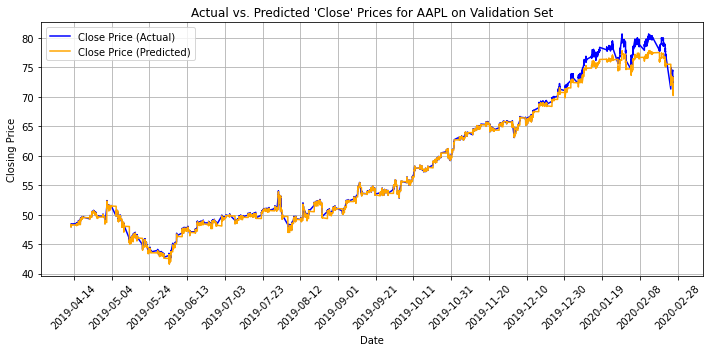

In [79]:
plot_actual_vs_predicted(pred_df_dict_valid, predict=predict, title=f"Actual vs. Predicted '{predict}' Prices for {stocks[0]} on Validation Set")

#### Q8. Predictions on Test Data <a id="q8"></a>
> Test the trading system on the latest years on which the model was not trained.

In [24]:
def test_model(model, test_loader):
    """
    Test function
    
    Parameters:
    - model (LSTM): Trained LSTM model.
    - test_loader (DataLoader): Test data loader.
    
    Returns:
    - tuple: Predicted values and test losses.
    """
    # Transfer the model to the device and set to evaluation mode
    model = model.to(device)
    model.eval()

    # Define the loss function
    criterion = nn.MSELoss()

    # Lists to store the test losses and predictions
    test_losses = []
    predictions = []

    # Using tqdm for the test loop to display a progress bar
    pbar = tqdm(test_loader, total=len(test_loader), leave=False)

    with torch.no_grad(): # Ensure no gradients are computed
        for _, batch in enumerate(pbar):
            # Transfer sequences and labels to device
            X_batch, Y_batch = batch[0].to(device), batch[1].to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            test_losses.append(loss.item())
            
            # Collect the predictions (move them to CPU for further analysis)
            batch_predictions = outputs.cpu().numpy().flatten()  # Flatten here
            predictions.extend(batch_predictions)
            
            # Update progress bar
            pbar.set_postfix(test_loss=loss.item())

    avg_test_loss = sum(test_losses) / len(test_loader.dataset)
    print(f'Average Test Loss: {avg_test_loss}')

    return predictions, test_losses

In [82]:
Y_test_pred, test_losses = test_model(trained_model, test_loader)

Average Test Loss: 0.0014904983444043907


Descaling the predictions and targets to their original scale.

In [83]:
Y_test_descaled = descale_data(scaled_data=Y_test, stock=stocks[0], column=predict, scalers_dict=scalers_dict)
Y_test_pred_descaled = descale_data(scaled_data=Y_test_pred, stock=stocks[0], column=predict, scalers_dict=scalers_dict)

> Q8a. Does the price prediction error increase as you go further from the last time on which it
was trained?

In [84]:
print(Y_test_descaled.flatten())
print(Y_test_pred_descaled.flatten())

[ 71.9217  72.0771  72.1856 ... 164.83   164.87   164.85  ]
[ 71.23587  71.29454  71.34313 ... 112.21177 112.23665 112.27584]


In [93]:
print(test_losses)

[7.883492799010128e-05, 5.8995232393499464e-05, 5.72575991100166e-05, 1.7635176845942624e-05, 1.8950056983157992e-05, 1.0497607945580967e-05, 1.6974354366539046e-05, 9.947187209036201e-06, 5.772825716121588e-06, 3.5054952604696155e-05, 4.79192822240293e-05, 4.79361588077154e-05, 0.00011466979049146175, 6.581397610716522e-05, 4.409372195368633e-05, 8.231688116211444e-05, 9.230617433786392e-05, 0.00011460783571237698, 0.00010520554496906698, 8.830862498143688e-05, 7.147210999391973e-05, 4.463129153009504e-05, 2.4067992853815667e-05, 2.1602972992695868e-05, 5.22627669852227e-05, 8.868903023540042e-06, 4.4326397983240895e-06, 2.1981819372740574e-05, 9.009638233692385e-06, 9.475204024056438e-06, 1.696493200142868e-05, 8.664022971061058e-06, 6.555564596055774e-06, 3.273062611697242e-05, 1.0645056136127096e-05, 1.038727077684598e-05, 2.9142516723368317e-05, 5.292383775667986e-06, 4.281673682271503e-06, 8.91404488356784e-05, 3.19214018418279e-06, 3.405826646485366e-06, 1.2820903066312894e-05, 

We can notice that prediction error increases as we go further from the last time on which it was trained. This is visible from the gap between the later values of `Y_test_descaled` and `Y_test_pred_descaled`. The gap increases as we go further from the last time on which it was trained. Also the test losses increases as we go further in time

Creating Dataframe of Test Predictions

In [85]:
pred_df_dict_test = create_pred_df_dict(test_df_dict, Y_test_descaled, Y_test_pred_descaled, seq_length=seq_length, predict=predict, pred_horizon=pred_horizon)
print(f"'{stocks[0]}': {predict} (Actual) vs. {predict} (Predicted) on Test Set:")
pred_df_dict_test[stocks[0]]

'AAPL': Close (Actual) vs. Close (Predicted) on Test Set:


,DateTime,Close (Actual),Close (Predicted)
2329235,2020-02-26 09:39:00,71.921700,71.235870
2329236,2020-02-26 09:40:00,72.077103,71.294540
2329237,2020-02-26 09:41:00,72.185600,71.343132
2329238,2020-02-26 09:42:00,72.151100,71.426865
2329239,2020-02-26 09:43:00,72.342201,71.487717
...,...,...,...
2743294,2022-02-25 15:56:00,164.825012,112.233421
2743295,2022-02-25 15:57:00,164.779999,112.243416
2743296,2022-02-25 15:58:00,164.830002,112.211769
2743297,2022-02-25 15:59:00,164.869995,112.236649


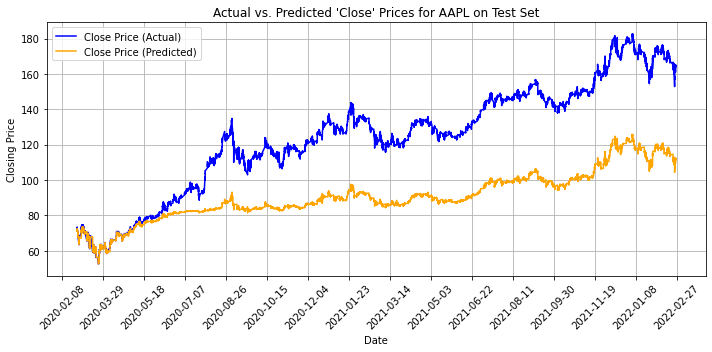

In [86]:
plot_actual_vs_predicted(pred_df_dict_test, predict=predict, title=f"Actual vs. Predicted '{predict}' Prices for {stocks[0]} on Test Set")

### LSTM Main Function <a id="lstm-main-function"></a>
- In the following cell, we have the main function for LSTM model, where we can specify the stock and the hyperparameters for the model and get all the plots and results using just one function. The function calls all the necessary functions that I made above.

In [25]:
def LSTM_main(stocks, hyperparameters, analyse=False, plot_loss=False, plot_actual_vs_pred=False):
    """
    Main function to execute the LSTM training, evaluation, and plotting processes.

    Parameters:
    - stocks (list): List of stock tickers.
    - hyperparameters (dict): Dictionary containing hyperparameters and other settings.
    - analyse (bool, optional): If True, performs an analysis on the stocks. Defaults to False.
    - plot_loss (bool, optional): If True, plots the training and validation losses. Defaults to False.
    - plot_actual_vs_pred (bool, optional): If True, plots the actual vs predicted values. Defaults to False.
    """
    
    # Analyse the stocks
    if analyse:
        analyse_stocks(stocks, disp_df=True, plot=True)
    
    # Creating df_dict, scaling, and making X and Y's
    df_dict = create_df_dict(stocks)
    latest_df_dict = get_latest_df_dict(df_dict, hyperparameters['years_to_keep'])
    processed_df_dict = process_df_dict(latest_df_dict)
    scaled_df_dict, scalers_dict = scale_df_dict(processed_df_dict)
    train_df_dict, valid_df_dict, test_df_dict = train_test_df_split(scaled_df_dict)
    
    # Making X and Y's
    X_train, Y_train = df_to_tensors(train_df_dict[stocks[0]], seq_length=hyperparameters['seq_length'], pred_horizon=hyperparameters['pred_horizon'], predict=hyperparameters['predict'])
    X_valid, Y_valid = df_to_tensors(valid_df_dict[stocks[0]], seq_length=hyperparameters['seq_length'], pred_horizon=hyperparameters['pred_horizon'], predict=hyperparameters['predict'])
    X_test, Y_test = df_to_tensors(test_df_dict[stocks[0]], seq_length=hyperparameters['seq_length'], pred_horizon=hyperparameters['pred_horizon'], predict=hyperparameters['predict'])
    
    # Getting training, validation, and test data loaders
    train_dataset = StockDataset(X_train, Y_train)
    valid_dataset = StockDataset(X_valid, Y_valid)
    test_dataset = StockDataset(X_test, Y_test)
    train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True, num_workers=16, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=hyperparameters['batch_size'], shuffle=False, num_workers=16, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False, num_workers=16, pin_memory=True)
    
    # Training the model
    print("Training model...")
    model = LSTM(input_dim=X_train.shape[2], hidden_dim=hyperparameters['hidden_dim'], num_layers=hyperparameters['num_layers'], output_dim=Y_train.shape[1])
    trained_model, train_losses, valid_losses = train_model(model, stocks, train_loader, valid_loader, num_epochs=hyperparameters['epochs'], learning_rate=hyperparameters['learning_rate'], regularize=hyperparameters['regularize'], weight_decay=hyperparameters['weight_decay'], save_best=hyperparameters['save_best'], patience=hyperparameters['patience'])
    
    # Plotting training and validation losses
    if plot_loss:
        plot_title = f"Training and Validation Losses for {stocks[0]}"
        plot_losses(train_losses, valid_losses, title=plot_title)
    
    # Getting predictions on the validation set
    with torch.no_grad():
        Y_valid_pred = trained_model(X_valid.to(device)).to('cpu').numpy()
    Y_valid_descaled = descale_data(scaled_data=Y_valid, stock=stocks[0], column=hyperparameters['predict'], scalers_dict=scalers_dict)
    Y_valid_pred_descaled = descale_data(scaled_data=Y_valid_pred, stock=stocks[0], column=hyperparameters['predict'], scalers_dict=scalers_dict)
    pred_df_dict_valid = create_pred_df_dict(valid_df_dict, Y_valid_descaled, Y_valid_pred_descaled, seq_length=hyperparameters['seq_length'], predict=hyperparameters['predict'], pred_horizon=hyperparameters['pred_horizon'])
    print(f"Predictions on the validation set for {stocks[0]}:")
    pred_df_dict_valid = create_pred_df_dict(valid_df_dict, Y_valid_descaled, Y_valid_pred_descaled, seq_length=hyperparameters['seq_length'], predict=hyperparameters['predict'], pred_horizon=hyperparameters['pred_horizon'])
    print(pred_df_dict_valid[stocks[0]])
        
    # Getting predictions on the test set
    Y_test_pred, _ = test_model(trained_model, test_loader)
    Y_test_descaled = descale_data(scaled_data=Y_test, stock=stocks[0], column=hyperparameters['predict'], scalers_dict=scalers_dict)
    Y_test_pred_descaled = descale_data(scaled_data=Y_test_pred, stock=stocks[0], column=hyperparameters['predict'], scalers_dict=scalers_dict)
    pred_df_dict_test = create_pred_df_dict(test_df_dict, Y_test_descaled, Y_test_pred_descaled, seq_length=hyperparameters['seq_length'], predict=hyperparameters['predict'], pred_horizon=hyperparameters['pred_horizon'])
    print(f"Predictions on the test set for {stocks[0]}:")
    pred_df_dict_test = create_pred_df_dict(test_df_dict, Y_test_descaled, Y_test_pred_descaled, seq_length=hyperparameters['seq_length'], predict=hyperparameters['predict'], pred_horizon=hyperparameters['pred_horizon'])
    print(pred_df_dict_test[stocks[0]])
    
    # Plotting actual vs predicted values    
    if plot_actual_vs_pred:
        plot_title = f"Actual vs. Predicted '{hyperparameters['predict']}' Prices for {stocks[0]} on Validation Set"
        plot_actual_vs_predicted(pred_df_dict_valid, predict=hyperparameters['predict'], title=plot_title)
        plot_title = f"Actual vs. Predicted '{hyperparameters['predict']}' Prices for {stocks[0]} on Test Set"
        plot_actual_vs_predicted(pred_df_dict_test, predict=hyperparameters['predict'], title=plot_title)
    return model, pred_df_dict_valid, pred_df_dict_test

Specify the stock name and the hyperparameters to be used for the model.

In [26]:
stocks = ["AAPL"]
hyperparameters = {
    'batch_size': 128,
    'random_seed': 42,
    'few_stocks': 4,
    'start_date': '2020-01-01',
    'end_date': '2020-02-01',
    'seq_length': 50,                   
    'pred_horizon': 5,          # Let us now predict 5 minutes into the future          
    'predict': 'Close',
    'hidden_dim': 32,
    'num_layers': 1,
    'epochs': 10,
    'learning_rate': 0.01,
    'weight_decay': 0.03,
    'regularize': False,
    'years_to_keep': 10,
    'patience': 4,
    'save_best': False
}

Call the main function for LSTM model.

Stock: AAPL


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,15.9429,15.9575,15.9365,15.9406,5096196
1035635,2012-02-27 09:31:00,15.9438,15.9554,15.9059,15.9093,3473680
1035636,2012-02-27 09:32:00,15.9096,15.9625,15.9093,15.9564,2646364
1035637,2012-02-27 09:33:00,15.9503,15.9695,15.9368,15.9486,3405192
1035638,2012-02-27 09:34:00,15.9513,15.9518,15.9334,15.9334,1566936
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,164.8711,164.9100,164.7600,164.8250,291553
2743295,2022-02-25 15:57:00,164.8400,164.8400,164.6500,164.7800,377280
2743296,2022-02-25 15:58:00,164.7900,164.8600,164.7500,164.8300,499079
2743297,2022-02-25 15:59:00,164.8300,164.9100,164.5900,164.8700,1056592


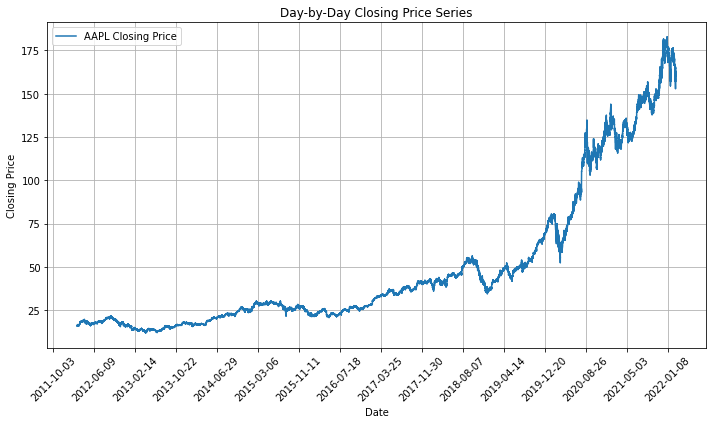

Training model...


####################################################################################################
Epoch: [1/10] | Epoch Train Loss: 4.515526968487621e-06 | Epoch Valid Loss: 1.2256544201158737e-06
####################################################################################################


####################################################################################################
Epoch: [2/10] | Epoch Train Loss: 1.1726700250528747e-07 | Epoch Valid Loss: 1.0811930234752847e-07
####################################################################################################


####################################################################################################
Epoch: [3/10] | Epoch Train Loss: 7.065688957641286e-08 | Epoch Valid Loss: 1.0491179970428838e-07
####################################################################################################


####################################################################################################
Epoch: [4/10] | Epoch Train Loss: 5.0893282013952395e-08 | Epoch Valid Loss: 3.5623749408962394e-08
####################################################################################################


####################################################################################################
Epoch: [5/10] | Epoch Train Loss: 5.4449485245022537e-08 | Epoch Valid Loss: 1.2478752123141983e-07
####################################################################################################


####################################################################################################
Epoch: [6/10] | Epoch Train Loss: 3.5648607808147757e-08 | Epoch Valid Loss: 5.481466827615406e-08
####################################################################################################


####################################################################################################
Epoch: [7/10] | Epoch Train Loss: 3.081745394867504e-08 | Epoch Valid Loss: 1.2070231331121959e-07
####################################################################################################


####################################################################################################
Epoch: [8/10] | Epoch Train Loss: 2.8139268884495485e-08 | Epoch Valid Loss: 2.1700943069078036e-07
####################################################################################################
Early stopping!!, Since validation loss has not improved in the last 4 epochs.


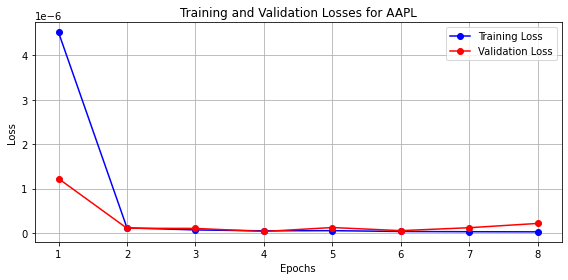

Predictions on the validation set for AAPL:
                   DateTime  Close (Actual)  Close (Predicted)
2182150 2019-04-12 12:21:00       48.128395          48.352196
2182151 2019-04-12 12:22:00       48.123501          48.360596
2182152 2019-04-12 12:23:00       48.122498          48.357273
2182153 2019-04-12 12:24:00       48.091896          48.348526
2182154 2019-04-12 12:25:00       48.104000          48.347351
...                     ...             ...                ...
2328740 2020-02-25 15:51:00       71.142395          71.675751
2328741 2020-02-25 15:52:00       70.996902          71.609955
2328742 2020-02-25 15:53:00       71.103004          71.575394
2328743 2020-02-25 15:54:00       71.110397          71.623650
2328744 2020-02-25 15:55:00       71.043800          71.636642

[74871 rows x 3 columns]


Average Test Loss: 5.6944101586278766e-05
Predictions on the test set for AAPL:
                   DateTime  Close (Actual)  Close (Predicted)
2329275 2020-02-26 10:19:00       72.654205          73.037445
2329276 2020-02-26 10:20:00       72.722504          73.108681
2329277 2020-02-26 10:21:00       72.649200          73.211563
2329278 2020-02-26 10:22:00       72.693100          73.325661
2329279 2020-02-26 10:23:00       72.915596          73.379646
...                     ...             ...                ...
2743290 2022-02-25 15:52:00      164.825012         151.174698
2743291 2022-02-25 15:53:00      164.779999         151.195618
2743292 2022-02-25 15:54:00      164.830002         151.268982
2743293 2022-02-25 15:55:00      164.869995         151.252686
2743294 2022-02-25 15:56:00      164.850006         151.245941

[183815 rows x 3 columns]


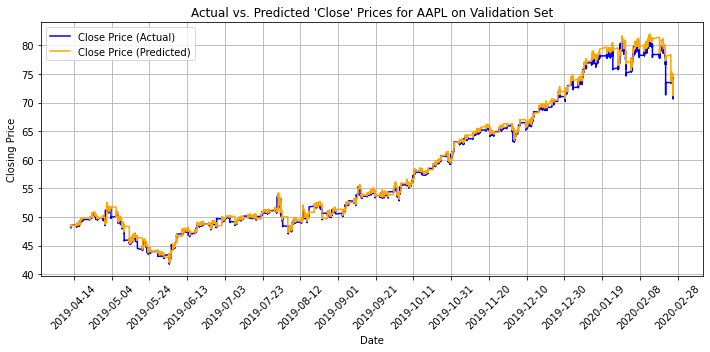

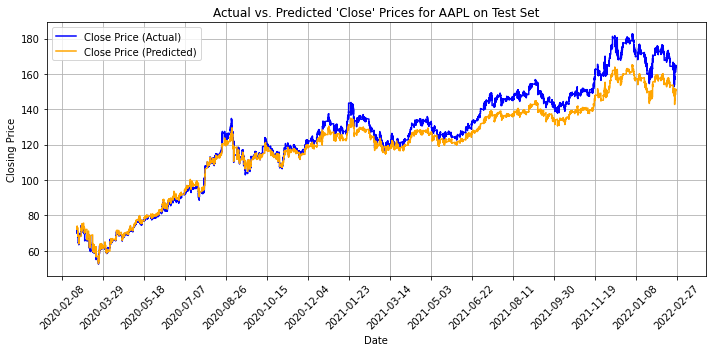

In [52]:
model, pred_df_dict_valid, pred_df_dict_test = LSTM_main(stocks, hyperparameters, analyse=True, plot_loss=True, plot_actual_vs_pred=True)

> Q8c. How does your profitability compare to a simple buy-and-hold strategy over long term (e.g.
one or two years)?

### Q7. Trading Module <a id="q7"></a>
> Set up a trading module that will make some hard-coded logical decisions to buy, hold, sell (in any
order, because in shorting you can sell first and buy later).

Let us first get pred_df_dict for some stock 

In [266]:
stocks = ["AAPL"]
hyperparameters = {
    'batch_size': 128,
    'random_seed': 42,
    'few_stocks': 4,
    'start_date': '2020-01-01',
    'end_date': '2020-02-01',
    'seq_length': 50,                   
    'pred_horizon': 5,                  
    'predict': 'Close',
    'hidden_dim': 32,
    'num_layers': 1,
    'epochs': 10,
    'learning_rate': 0.01,
    'weight_decay': 0.03,
    'regularize': False,
    'years_to_keep': 10,
    'patience': 4,
    'save_best': False
}

Stock: AAPL


,DateTime,Open,High,Low,Close,Volume
1035634,2012-02-27 09:30:00,15.9429,15.9575,15.9365,15.9406,5096196
1035635,2012-02-27 09:31:00,15.9438,15.9554,15.9059,15.9093,3473680
1035636,2012-02-27 09:32:00,15.9096,15.9625,15.9093,15.9564,2646364
1035637,2012-02-27 09:33:00,15.9503,15.9695,15.9368,15.9486,3405192
1035638,2012-02-27 09:34:00,15.9513,15.9518,15.9334,15.9334,1566936
...,...,...,...,...,...,...
2743294,2022-02-25 15:56:00,164.8711,164.9100,164.7600,164.8250,291553
2743295,2022-02-25 15:57:00,164.8400,164.8400,164.6500,164.7800,377280
2743296,2022-02-25 15:58:00,164.7900,164.8600,164.7500,164.8300,499079
2743297,2022-02-25 15:59:00,164.8300,164.9100,164.5900,164.8700,1056592


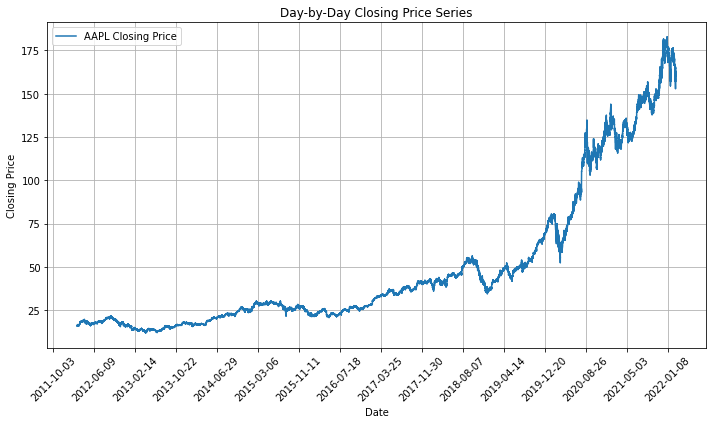

Training model...


####################################################################################################
Epoch: [1/10] | Epoch Train Loss: 5.6276450726197005e-06 | Epoch Valid Loss: 2.7346940533401557e-07
####################################################################################################


####################################################################################################
Epoch: [2/10] | Epoch Train Loss: 1.1026797831552629e-07 | Epoch Valid Loss: 4.5458158062751906e-08
####################################################################################################


####################################################################################################
Epoch: [3/10] | Epoch Train Loss: 6.558843494145006e-08 | Epoch Valid Loss: 3.864127529483194e-08
####################################################################################################


####################################################################################################
Epoch: [4/10] | Epoch Train Loss: 4.868153699972748e-08 | Epoch Valid Loss: 4.1017795308197624e-08
####################################################################################################


####################################################################################################
Epoch: [5/10] | Epoch Train Loss: 4.0436227365246776e-08 | Epoch Valid Loss: 2.752388885989307e-08
####################################################################################################


####################################################################################################
Epoch: [6/10] | Epoch Train Loss: 3.546735527222362e-08 | Epoch Valid Loss: 6.112386261126523e-08
####################################################################################################


####################################################################################################
Epoch: [7/10] | Epoch Train Loss: 3.265896908161653e-08 | Epoch Valid Loss: 1.7511106829029065e-08
####################################################################################################


####################################################################################################
Epoch: [8/10] | Epoch Train Loss: 2.8858966104037778e-08 | Epoch Valid Loss: 2.0068197427076486e-07
####################################################################################################


####################################################################################################
Epoch: [9/10] | Epoch Train Loss: 2.6650596787978292e-08 | Epoch Valid Loss: 3.3928450986257177e-07
####################################################################################################


####################################################################################################
Epoch: [10/10] | Epoch Train Loss: 2.4110303913665624e-08 | Epoch Valid Loss: 1.384133894444788e-06
####################################################################################################
Predictions on the validation set for AAPL:
                   DateTime  Close (Actual)  Close (Predicted)
2182150 2019-04-12 12:21:00       48.128395          48.120937
2182151 2019-04-12 12:22:00       48.123501          48.130463
2182152 2019-04-12 12:23:00       48.122498          48.123348
2182153 2019-04-12 12:24:00       48.091896          48.113319
2182154 2019-04-12 12:25:00       48.104000          48.113930
...                     ...             ...                ...
2328740 2020-02-25 15:51:00       71.142395          72.114014
2328741 2020-02-25 15:52:00       70.996902          72.050293
2328742 2020-02-25 15:53:00       71.103004          72.017303
2328743 2020-02-25 15:54

Average Test Loss: 0.0003632320730150749
Predictions on the test set for AAPL:
                   DateTime  Close (Actual)  Close (Predicted)
2329275 2020-02-26 10:19:00       72.654205          73.691124
2329276 2020-02-26 10:20:00       72.722504          73.773201
2329277 2020-02-26 10:21:00       72.649200          73.895935
2329278 2020-02-26 10:22:00       72.693100          74.017509
2329279 2020-02-26 10:23:00       72.915596          74.076172
...                     ...             ...                ...
2743290 2022-02-25 15:52:00      164.825012         187.314270
2743291 2022-02-25 15:53:00      164.779999         187.345718
2743292 2022-02-25 15:54:00      164.830002         187.451904
2743293 2022-02-25 15:55:00      164.869995         187.436554
2743294 2022-02-25 15:56:00      164.850006         187.423004

[183815 rows x 3 columns]


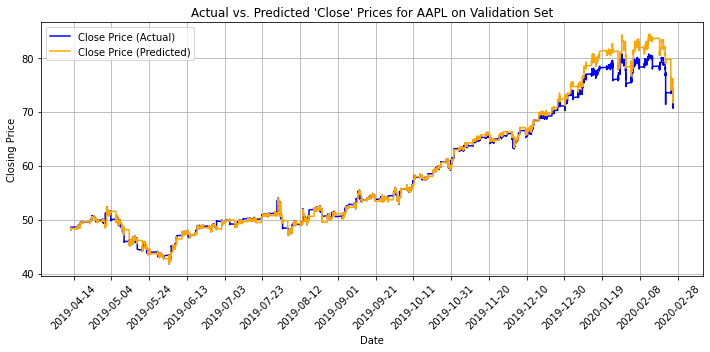

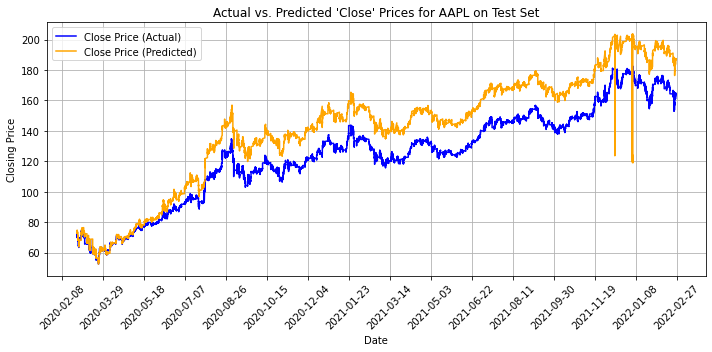

In [267]:
model, pred_df_dict_valid, pred_df_dict_test = LSTM_main(stocks, hyperparameters, analyse=True, plot_loss=False, plot_actual_vs_pred=True)

### Triple EMA Crossover Strategy <a id="triple-ema-crossover-strategy"></a>
I am using the Triple EMA Crossover Strategy here. It utilizes three Exponential Moving Averages (EMAs) of varying lengths to identify potential entry and exit points in the market (reference [[13]](#references)). The three EMAs are as follows: 
- **Short or Fast EMA:** which is calculated over a short period of time, say 9 days
- **Middle or Medium EMA:** which is calculated over a medium period of time, say 21 days
- **Long or Slow EMA:** which is calculated over a long period of time, say 55 days

Code snippet for the following cell is referred from [[13]](#references) and [[14]](#references).

In [292]:
def create_tema_df_dict(pred_df_dict, column):
    tema_df_dict = {}
    for stock, df in pred_df_dict.items():
        df = df.copy()
        df.set_index('DateTime', inplace=True)
        
        # Resampling the data to daily frequency for better visualization
        if column == "Open":
            df_daily = df.resample('D').first()
        else:  # Assuming 'Close' or other column
            df_daily = df.resample('D').last()

        # Drop NaN rows which might occur if there's no data for some days
        df_daily.dropna(inplace=True)

        # Calculate the EMAs on the resampled data
        df_daily['Short_EMA'] = df_daily[column].ewm(span=9, adjust=False).mean()
        df_daily['Middle_EMA'] = df_daily[column].ewm(span=21, adjust=False).mean()
        df_daily['Long_EMA'] = df_daily[column].ewm(span=55, adjust=False).mean()

        tema_df_dict[stock] = df_daily.reset_index()
    return tema_df_dict

Note that I am using Close (Actual) values for calculating the EMAs. This is for validation Dataframe only.

In [293]:
tema_df_dict_valid = create_tema_df_dict(pred_df_dict_valid, column = f"{hyperparameters['predict']} (Actual)")
print(f"Triple EMA Crossover Dataframe for '{stocks[0]} - {hyperparameters['predict']} (Actual)':")
tema_df_dict_valid[stocks[0]]

Triple EMA Crossover Dataframe for 'AAPL - Close (Actual)' over Valditaion set:


,DateTime,Close (Actual),Close (Predicted),Date,Time,Short_EMA,Middle_EMA,Long_EMA
0,2019-04-12,48.600597,48.365551,2019-04-12,16:00:00,48.600597,48.600597,48.600597
1,2019-04-15,48.503201,48.451466,2019-04-15,16:00:00,48.581118,48.591743,48.597119
2,2019-04-16,48.683395,48.495533,2019-04-16,16:00:00,48.601573,48.600075,48.600200
3,2019-04-17,49.498802,49.414520,2019-04-17,16:00:00,48.781019,48.681778,48.632293
4,2019-04-18,49.586399,49.606350,2019-04-18,16:00:00,48.942095,48.764016,48.666368
...,...,...,...,...,...,...,...,...
214,2020-02-19,79.920601,83.081726,2020-02-19,16:00:00,79.300042,78.375173,74.181576
215,2020-02-20,78.925499,81.990776,2020-02-20,16:00:00,79.225133,78.425203,74.351002
216,2020-02-21,73.517296,79.625870,2020-02-21,16:00:00,78.083566,77.979030,74.321227
217,2020-02-24,74.228302,75.082573,2020-02-24,16:00:00,77.312513,77.638054,74.317908


#### Buy and Sell Signals <a id="buy-and-sell-signals"></a>
**Buy Signal:** When the `Short EMA` crosses above the `Middle EMA` and the `Middle EMA` is above the `Long EMA`, it suggests that the recent price movement is upward, and this upward trend is expected to continue in the near future. Hence, it might be a good time to buy.

**Sell Signal:** When the `Short EMA` crosses below the `Middle EMA` or the `Middle EMA` crosses below the `Long EMA`, it indicates a potential change in the trend or a confirmation that the trend has changed to a downward direction. If we hold the stock, it might be a good time to sell.

In [294]:
def generate_signals(tema_df):
    buy_signals = []
    sell_signals = []
    
    position = 0  # 0: no position, 1: holding the stock
    
    for i in range(1, len(tema_df)):
        # Buy Signal
        if tema_df['Short_EMA'].iloc[i] > tema_df['Middle_EMA'].iloc[i] and \
           tema_df['Short_EMA'].iloc[i-1] <= tema_df['Middle_EMA'].iloc[i-1] and \
           tema_df['Middle_EMA'].iloc[i] > tema_df['Long_EMA'].iloc[i] and \
           position == 0:
            buy_signals.append(tema_df.index[i])
            position = 1

        # Sell Signal
        elif (tema_df['Short_EMA'].iloc[i] < tema_df['Middle_EMA'].iloc[i] or \
              tema_df['Middle_EMA'].iloc[i] < tema_df['Long_EMA'].iloc[i]) and \
              position == 1:
            sell_signals.append(tema_df.index[i])
            position = 0

    return buy_signals, sell_signals

In [295]:
print(f"Buy and sell signals for '{stocks[0]}' on Validation Data:")
buy_signals, sell_signals = generate_signals(tema_df_dict_valid[stocks[0]])
print(f"Buy signals: {buy_signals}")
print(f"Sell signals: {sell_signals}")

Buy and sell signals for 'AAPL' on Validation Data:
Buy signals: [87]
Sell signals: [217]


We got some buy and sell signals for the stock. Let us now plot the signals on the actual stock price.

In [296]:
def buy_and_sell(tema_df_dict):
    buy_dict = {}
    sell_dict = {}
    
    for stock, df in tema_df_dict.items():
        buy_signals, sell_signals = generate_signals(df)
        buy_dict[stock] = buy_signals
        sell_dict[stock] = sell_signals

    return buy_dict, sell_dict

In [297]:
buy_dict, sell_dict = buy_and_sell(tema_df_dict_valid)

In [298]:
def plot_tema(tema_df_dict, buy_dict, sell_dict, predict):
    tema_df_dict = separate_datetime_dfs_dict(tema_df_dict)
    for stock, df in tema_df_dict.items():
        fig, ax = plt.subplots(figsize=(15, 10))
        
        ax.plot(df['Date'], df[predict], label=f'{predict} Price', color='blue')
        ax.plot(df['Date'], df['Short_EMA'], label='Short EMA', color='orange')
        ax.plot(df['Date'], df['Middle_EMA'], label='Middle EMA', color='green')
        ax.plot(df['Date'], df['Long_EMA'], label='Long EMA', color='red')
        
        # Extract buy and sell dates for this specific stock
        buy_dates = [date for date in buy_dict[stock] if date in df.index]
        sell_dates = [date for date in sell_dict[stock] if date in df.index]
        
        # Increase the marker size using the `s` parameter
        ax.scatter(df.loc[buy_dates, 'Date'], df.loc[buy_dates, predict], marker='^', color='green', label='Buy Signal', s=220)
        ax.scatter(df.loc[sell_dates, 'Date'], df.loc[sell_dates, predict], marker='v', color='red', label='Sell Signal', s=220)
        
        title = f"Triple Exponential Moving Average Plot for {stock}-{predict}"
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Date', fontsize=16)
        ax.set_ylabel('Closing Price', fontsize=16)
        ax.legend()
        ax.grid(True)
        ax.xaxis.set_major_locator(plt.MaxNLocator(20))
        ax.xaxis.set_tick_params(rotation=45)
        plt.tight_layout()
        plt.show()

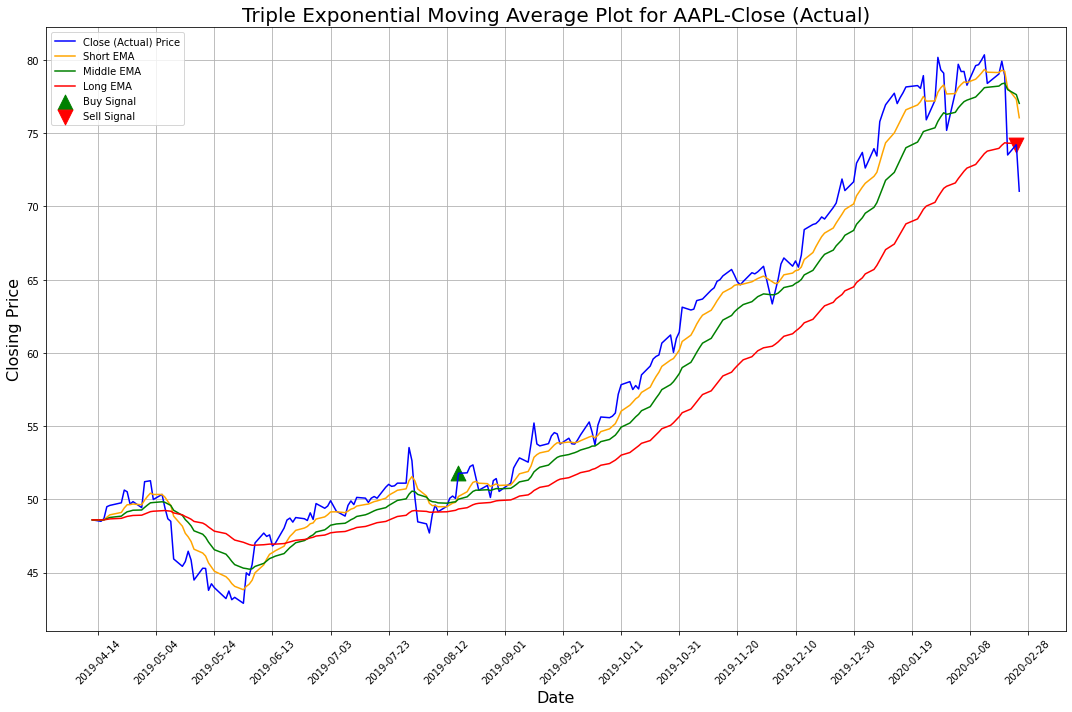

In [299]:
plot_tema(tema_df_dict_valid, buy_dict, sell_dict, predict=f'{hyperparameters["predict"]} (Actual)')

Now let us check the performance of Triple EMA Crossover Strategy on the test data. But this time we will use the predicted values for calculating the EMAs.

In [302]:
tema_df_dict_test = create_tema_df_dict(pred_df_dict_test, column = f"{hyperparameters['predict']} (Predicted)") # Using predicted values 
print(f"Triple EMA Crossover Dataframe for '{stocks[0]} - {predict} (Predicted)' over Valditaion set:")
tema_df_dict_test[stocks[0]]

Triple EMA Crossover Dataframe for 'AAPL - Close (Predicted)' over Valditaion set:


,DateTime,Close (Actual),Close (Predicted),Date,Time,Short_EMA,Middle_EMA,Long_EMA
0,2020-02-26,69.978897,73.414253,2020-02-26,16:00:00,73.414253,73.414253,73.414253
1,2020-02-27,64.404999,68.078049,2020-02-27,16:00:00,72.347012,72.929144,73.223675
2,2020-02-28,69.561600,67.929352,2020-02-28,16:00:00,71.463480,72.474617,73.034592
3,2020-03-02,74.372299,75.106926,2020-03-02,16:00:00,72.192169,72.713918,73.108603
4,2020-03-03,73.287903,72.425896,2020-03-03,16:00:00,72.238915,72.687734,73.084221
...,...,...,...,...,...,...,...,...
501,2022-02-18,164.360001,190.018982,2022-02-18,16:00:00,192.938775,192.827336,190.098453
502,2022-02-22,165.684998,186.871811,2022-02-22,16:00:00,191.725382,192.285925,189.983216
503,2022-02-23,154.020004,183.028732,2022-02-23,16:00:00,189.986052,191.444362,189.734841
504,2022-02-24,162.479004,185.409332,2022-02-24,16:00:00,189.070708,190.895723,189.580359


In [304]:
buy_signals, sell_signals = generate_signals(tema_df_dict_test[stocks[0]])
buy_dict, sell_dict = buy_and_sell(tema_df_dict_test)
print(f"Buy and sell signals for '{stocks[0]}' on Test Data:")
print(f"Buy signals: {buy_signals}")
print(f"Sell signals: {sell_signals}")

Buy and sell signals for 'AAPL' on Test Data:
Buy signals: [154, 156, 179, 473, 488]
Sell signals: [155, 171, 246, 480, 502]


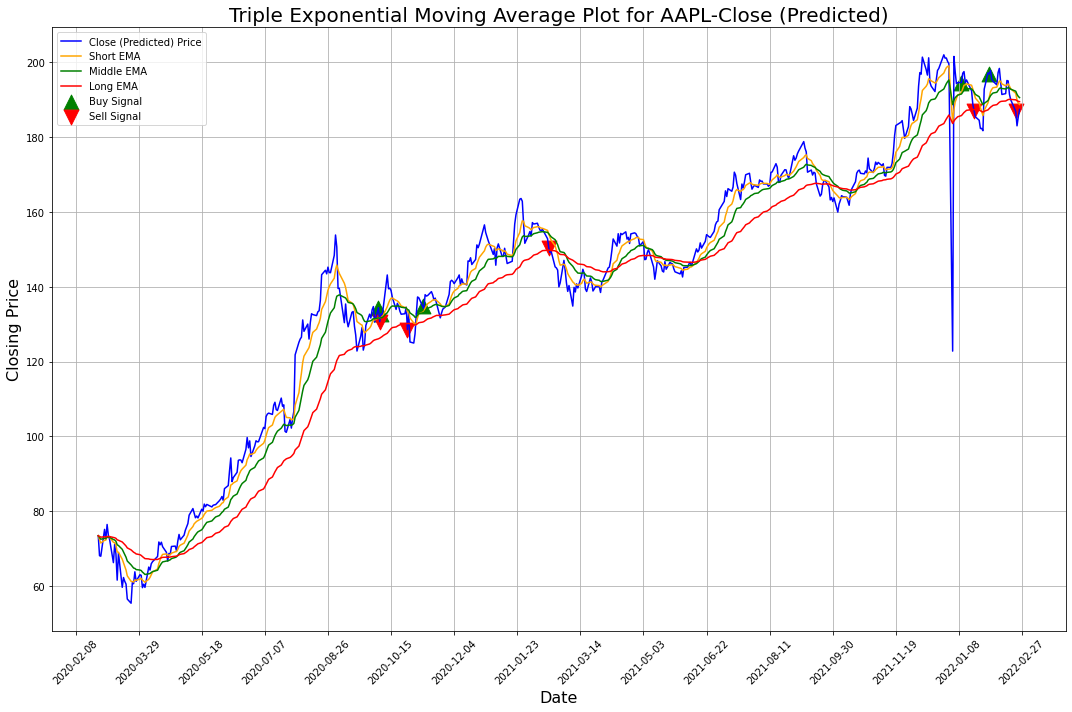

In [305]:
plot_tema(tema_df_dict_test, buy_dict, sell_dict, predict=f'{hyperparameters["predict"]} (Predicted)')

Let us combine above buy and sell signals and make a trading module function.

In [324]:
def trading_module(pred_df_dict_valid, pred_df_dict_test, predict):
    # Create tema_df_dict for validation and test sets
    tema_df_dict_valid = create_tema_df_dict(pred_df_dict_valid, column = f"{predict} (Actual)")
    tema_df_dict_test = create_tema_df_dict(pred_df_dict_test, column = f"{predict} (Predicted)")
    
    # Generate buy and sell signals for validation and test sets
    buy_signals_valid, sell_signals_valid = generate_signals(tema_df_dict_valid[stocks[0]])
    buy_signals_test, sell_signals_test = generate_signals(tema_df_dict_test[stocks[0]])
    
    # Create buy and sell dictionaries for validation and test sets
    buy_dict_valid, sell_dict_valid = buy_and_sell(tema_df_dict_valid)
    buy_dict_test, sell_dict_test = buy_and_sell(tema_df_dict_test)
    
    # Print buy and sell signals for validation set
    print(f"Buy and sell signals for '{stocks[0]}' on Validation Data:")
    print(f"Buy signals: {buy_signals_valid}")
    print(f"Sell signals: {sell_signals_valid}")
    plot_tema(tema_df_dict_valid, buy_dict_valid, sell_dict_valid, predict=f'{predict} (Actual)')
    
    # Print buy and sell signals for test set
    print(f"Buy and sell signals for '{stocks[0]}' on Test Data:")
    print(f"Buy signals: {buy_signals_test}")
    print(f"Sell signals: {sell_signals_test}")
    plot_tema(tema_df_dict_test, buy_dict_test, sell_dict_test, predict=f'{predict} (Predicted)')
    
    return tema_df_dict_valid, tema_df_dict_test, buy_dict_valid, sell_dict_valid, buy_dict_test, sell_dict_test

In [322]:
stocks = ["DRE"]
hyperparameters = {
    'batch_size': 128,
    'random_seed': 42,
    'few_stocks': 4,
    'start_date': '2020-01-01',
    'end_date': '2020-02-01',
    'seq_length': 10,                   
    'pred_horizon': 1,                  
    'predict': 'Open',
    'hidden_dim': 32,
    'num_layers': 1,
    'epochs': 10,
    'learning_rate': 0.01,
    'weight_decay': 0.03,
    'regularize': False,
    'years_to_keep': 10,
    'patience': 4,
    'save_best': False
}

Stock: DRE


,DateTime,Open,High,Low,Close,Volume
666941,2012-02-27 09:30:00,9.6321,9.6670,9.6321,9.6635,14615
666942,2012-02-27 09:31:00,9.6460,9.6530,9.6356,9.6460,11771
666943,2012-02-27 09:32:00,9.6391,9.6426,9.6356,9.6391,1600
666944,2012-02-27 09:33:00,9.6321,9.6391,9.6251,9.6265,9009
666945,2012-02-27 09:34:00,9.6251,9.6321,9.6042,9.6042,9580
...,...,...,...,...,...,...
1622684,2022-02-25 15:56:00,53.9800,54.0100,53.9750,54.0000,18205
1622685,2022-02-25 15:57:00,54.0000,54.0000,53.9400,53.9650,20354
1622686,2022-02-25 15:58:00,53.9700,53.9700,53.8900,53.9000,44818
1622687,2022-02-25 15:59:00,53.9000,53.9200,53.8900,53.9000,81474


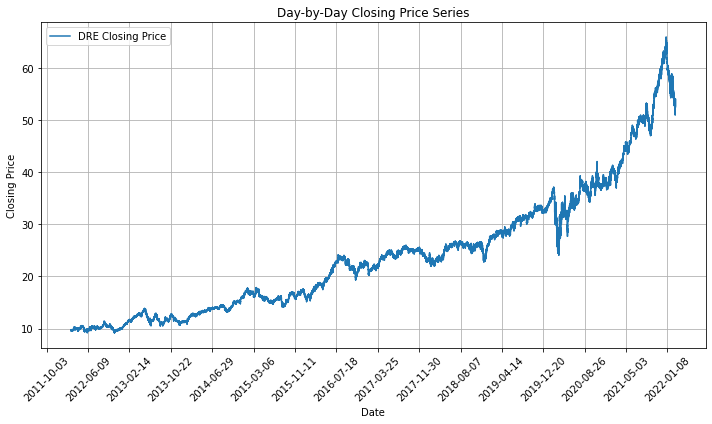

Training model...


####################################################################################################
Epoch: [1/10] | Epoch Train Loss: 2.3171242199198508e-06 | Epoch Valid Loss: 1.6368919002292193e-07
####################################################################################################


####################################################################################################
Epoch: [2/10] | Epoch Train Loss: 7.46114947105488e-08 | Epoch Valid Loss: 8.529197345902882e-08
####################################################################################################


####################################################################################################
Epoch: [3/10] | Epoch Train Loss: 4.5775920165922683e-08 | Epoch Valid Loss: 1.8999653555688557e-08
####################################################################################################


####################################################################################################
Epoch: [4/10] | Epoch Train Loss: 3.2570329219879664e-08 | Epoch Valid Loss: 7.530696490312163e-07
####################################################################################################


####################################################################################################
Epoch: [5/10] | Epoch Train Loss: 2.587108167698739e-08 | Epoch Valid Loss: 5.065660600132981e-06
####################################################################################################


####################################################################################################
Epoch: [6/10] | Epoch Train Loss: 2.2755045265803057e-08 | Epoch Valid Loss: 4.9972665845538786e-06
####################################################################################################


####################################################################################################
Epoch: [7/10] | Epoch Train Loss: 1.9147548183742756e-08 | Epoch Valid Loss: 2.102737874588791e-06
####################################################################################################
Early stopping!!, Since validation loss has not improved in the last 4 epochs.
Predictions on the validation set for DRE:
                   DateTime  Open (Actual)  Open (Predicted)
1353348 2019-05-13 15:24:00      28.188799         28.162880
1353349 2019-05-13 15:25:00      28.184099         28.155634
1353350 2019-05-13 15:26:00      28.179501         28.157080
1353351 2019-05-13 15:27:00      28.188799         28.151508
1353352 2019-05-13 15:28:00      28.188799         28.151968
...                     ...            ...               ...
1428842 2020-02-25 15:55:00      34.903603         35.817661
1428843 2020-02-25 15:56:00      34.932301         35.821651
1428844 2020-02-25 15:57:00 

Average Test Loss: 0.000137240600488465
Predictions on the test set for DRE:
                   DateTime  Open (Actual)  Open (Predicted)
1428859 2020-02-26 09:39:00      35.018200         35.972137
1428860 2020-02-26 09:40:00      35.037201         35.986721
1428861 2020-02-26 09:41:00      35.056301         35.983231
1428862 2020-02-26 09:42:00      35.037201         36.003944
1428863 2020-02-26 09:43:00      35.104000         36.024220
...                     ...            ...               ...
1622684 2022-02-25 15:56:00      53.980000         57.560436
1622685 2022-02-25 15:57:00      54.000000         57.573803
1622686 2022-02-25 15:58:00      53.969997         57.580368
1622687 2022-02-25 15:59:00      53.900002         57.619236
1622688 2022-02-25 16:00:00      53.889999         57.706680

[181953 rows x 3 columns]


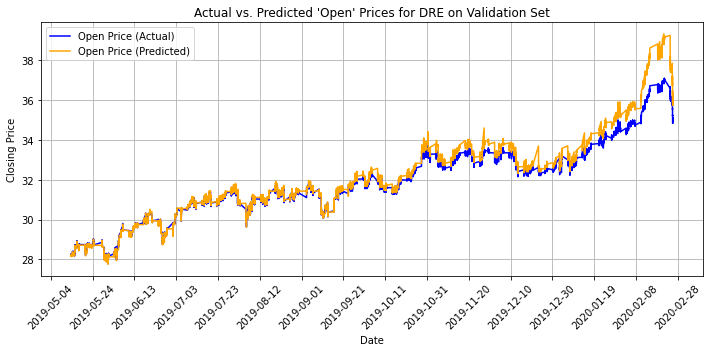

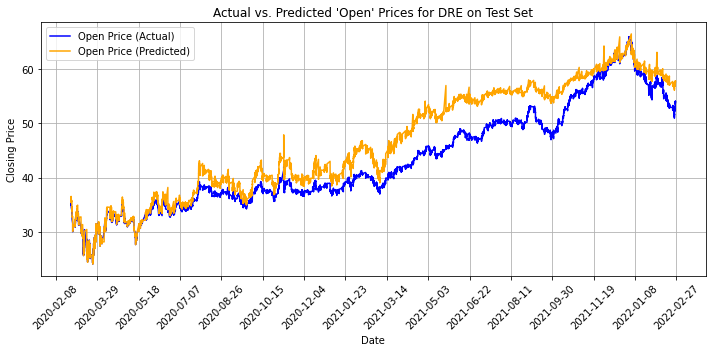

In [313]:
model, pred_df_dict_valid, pred_df_dict_test = LSTM_main(stocks, hyperparameters, analyse=True, plot_loss=False, plot_actual_vs_pred=True)

Buy and sell signals for 'DRE' on Validation Data:
Buy signals: [1, 16, 90, 166, 168]
Sell signals: [12, 83, 150, 167]


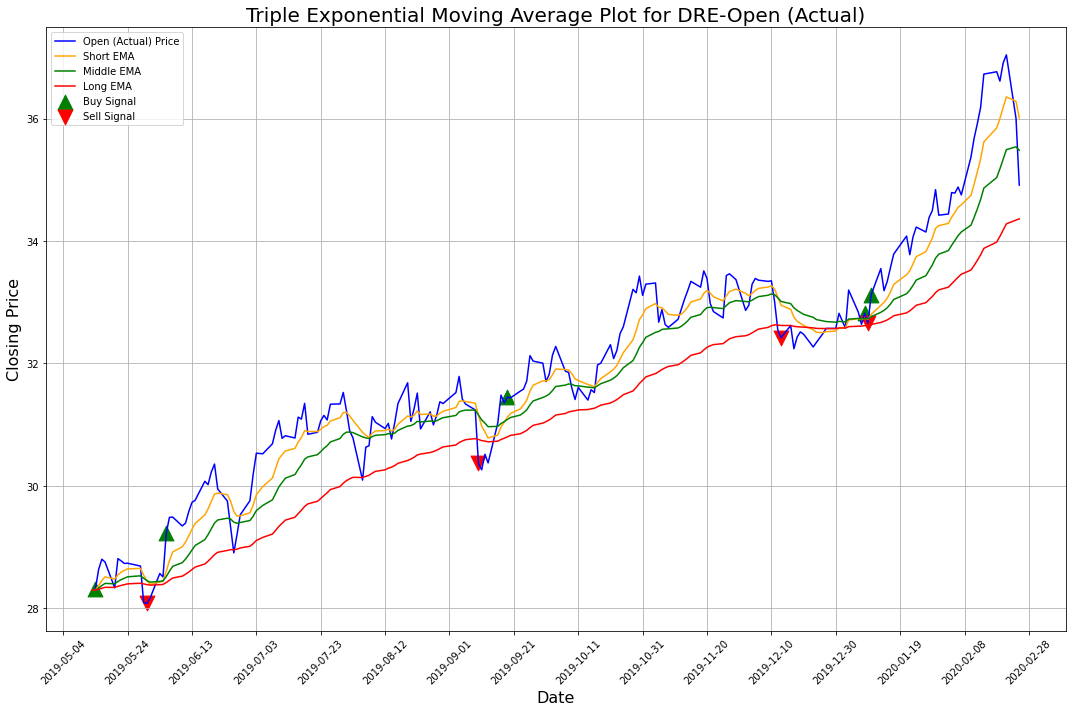

Buy and sell signals for 'DRE' on Test Data:
Buy signals: [88, 154, 175, 204, 227, 264, 381, 409]
Sell signals: [135, 171, 189, 218, 253, 378, 392, 473]


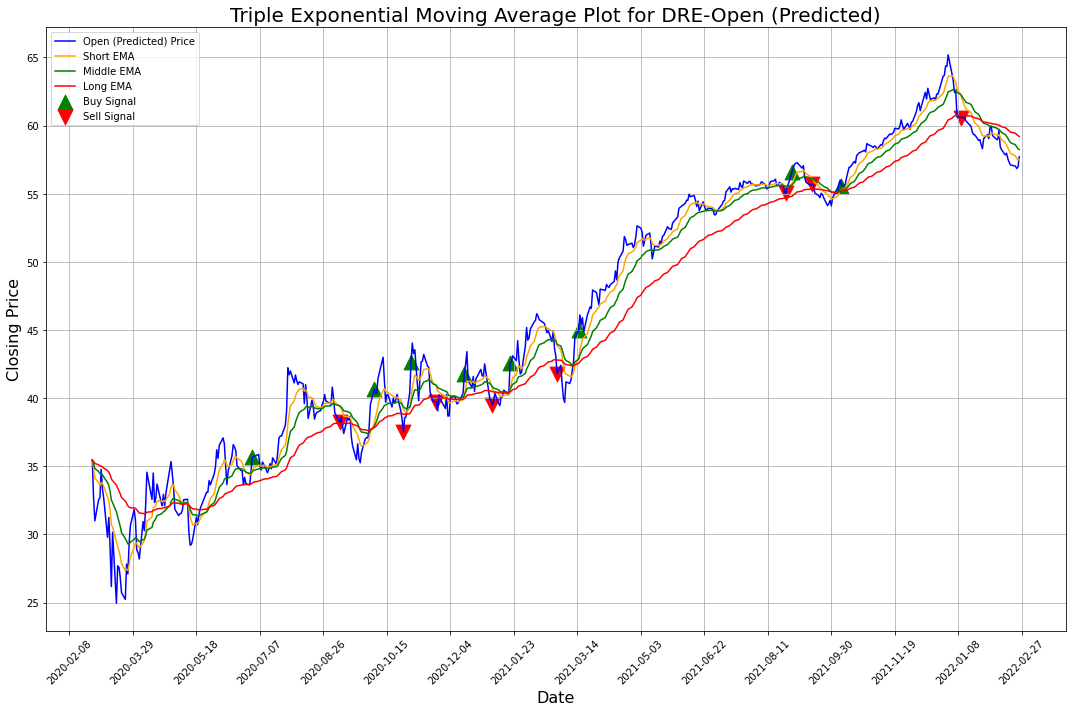

In [325]:
tema_df_dict_valid, tema_df_dict_test, buy_dict_valid, sell_dict_valid, buy_dict_test, sell_dict_test = trading_module(pred_df_dict_valid, pred_df_dict_test, predict=hyperparameters["predict"])

> Q8b. Can you profitably trade with the bid-ask spread and commissions taken into account?

In [336]:
def calculate_cost(tema_df, buy_signals, sell_signals, predict, spread_percentage=0.02, commission=2.0):
    """
    Calculate the total trade cost based on bid-ask spread and commission.
    """
    total_cost = 0.0
    num_trades = min(len(buy_signals), len(sell_signals))
    
    for i in range(num_trades):
        buy_price = tema_df[predict].loc[buy_signals[i]]
        sell_price = tema_df[predict].loc[sell_signals[i]]
        
        # Calculate spread cost for buying and selling
        spread_cost_buy = buy_price * (spread_percentage / 100)
        spread_cost_sell = sell_price * (spread_percentage / 100)
        
        # Total cost for this trade (buying and selling)
        trade_cost = spread_cost_buy + spread_cost_sell + 2 * commission
        
        total_cost += trade_cost
        
    return total_cost

In [334]:
print(len(buy_signals_valid), len(sell_signals_valid))

5 4


In [ ]:
total_trade_cost = calculate_cost(buy_signals_valid, sell_signals_valid, tema_df_dict_valid[stocks[0]], predict=f'{hyperparameters["predict"]} (Actual)')

### Q9. Advanced: Working with multiple stocks <a id="q9"></a>
> Q9a. Can you now modify the model to use multiple stock prices as inputs to predict a single
stock (your choice)? Does it improve predictions?

> Q9b. Can you add day of the week, day in year, and time as inputs? Does it improve results?

### References:   <a id="references"></a>
1. https://www.kaggle.com/datasets/camnugent/sandp500 
2. https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm 
3. https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-pandas/
4. https://coderzcolumn.com/tutorials/data-science/candlestick-chart-in-python-mplfinance-plotly-bokeh 
5. https://itadviser.dev/stock-market-data-normalization-for-time-series/#:~:text=Z%2Dscore%20normalization%2C%20also%20known,a%20standard%20deviation%20of%201.&text=Where%3A,Z%2Dscore%20(normalized%20value) 
6. https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ 
7. https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch
8. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html 
9. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 
10. OpenAI. (2023). ChatGPT (August 3 Version) [Large language model]. https://chat.openai.com
11. https://www.youtube.com/watch?v=q_HS4s1L8UI
12. https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py
13. https://www.investopedia.com/ask/answers/041315/why-triple-exponential-moving-average-tema-important-traders-and-analysts.asp
14. https://www.youtube.com/watch?v=rO_cqa4x60o&t=1s
15. https://finance.yahoo.com/quote/AAPL?p=AAPL
 